In [1]:
# ------------------------------------------define logging and working directory
from ProjectRoot import change_wd_to_project_root
change_wd_to_project_root()
import cv2
from ipyfilechooser import FileChooser
from src.utils.Notebook_imports import *
from src.utils.Tensorflow_helper import choose_gpu_by_id
from tensorflow.keras.utils import plot_model
from tensorflow.python.client import device_lib
import tensorflow as tf
tf.get_logger().setLevel('ERROR')
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
# ------------------------------------------define GPU id/s to use
GPU_IDS = '0,1'
GPUS = choose_gpu_by_id(GPU_IDS)
print(GPUS)

# ------------------------------------------jupyter magic config
%matplotlib inline
%reload_ext autoreload
%autoreload 2

# ------------------------------------------ import helpers
from src.utils.Utils_io import Console_and_file_logger, init_config
from src.utils.KerasCallbacks import get_callbacks
import src.utils.Loss_and_metrics as metr
from src.utils.Predict import predict_on_one_3d_file

from src.data.Dataset import get_reference_nrrd, copy_meta_and_save, get_trainings_files
from src.data.Preprocess import from_channel_to_flat, transform_to_binary_mask, normalise_image
from src.data.Generators import DataGenerator, CycleMotionDataGenerator
from src.data.Postprocess import clean_3d_prediction_3d_cc, undo_generator_steps

import src.models.SpatialTransformer as st
from src.models.SpatialTransformer import create_affine_cycle_transformer_model, create_affine_transformer_fixed
from src.models.KerasLayers import UnetWrapper
from src.models.ModelUtils import load_pretrained_model

from src.visualization.Visualize import show_2D_or_3D

# ------------------------------------------these metrics and loss function are meant if you continue training of the U-Net
metrics = [
    metr.dice_coef_labels,
    metr.dice_coef_myo,
    metr.dice_coef_lv,
    metr.dice_coef_rv
]
LOSS_FUNCTION = metr.bce_dice_loss

from tensorflow.keras.mixed_precision import experimental as mixed_precision
logging.info('Is built with tensorflow: {}'.format(tf.test.is_built_with_cuda()))
logging.info('Visible devices:\n{}'.format(tf.config.list_physical_devices()))
logging.info('Local devices: \n {}'.format(device_lib.list_local_devices()))
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_policy(policy)
logging.info('Compute dtype: %s' % policy.compute_dtype)
logging.info('Variable dtype: %s' % policy.variable_dtype)

search for root_dir and set working directory
Working directory set to: /mnt/ssd/git/3d-mri-domain-adaption
['/gpu:0', '/gpu:1']


# Load an ax-sax config into the global namespace

In [2]:
exp_config_chooser = FileChooser(os.path.join(os.getcwd(),'reports/configs/3D/ax_sax/train_on_ax_sax/fold0/2020-12-17_11_44/'), '')
display(exp_config_chooser)
@interact_manual
def load_unet():
    # load a pretrained 2D unet
    global exp_config_chooser, config
    """
    load ax-sax experiment config
    """
    if 'exp_config_chooser' in globals():
        config_file  = exp_config_chooser.selected
    else:
        # round the crop and pad values instead of ceil
        #config_file = 'reports/configs/3D/ax_sax/unetwithdownsamplingaugmentation_new_data/2020-12-03_18_20/config.json' # Fold 0
        #config_file = 'reports/configs/3D/ax_sax/unetwithdownsamplingaugmentation_new_data/2020-12-03_22_02/config.json' # Fold 1
        #config_file = 'reports/configs/3D/ax_sax/unetwithdownsamplingaugmentation_new_data/2020-12-04_16_56/config.json' # Fold 2
        #config_file = 'reports/configs/3D/ax_sax/unetwithdownsamplingaugmentation_new_data/2020-12-07_12_36/config.json' # Fold 3
        
        #config_file = 'reports/configs/3D/ax_sax/train_on_ax_sax/fold0/2020-12-17_11_44/config.json' # Fold 0
        #config_file = 'reports/configs/3D/ax_sax/train_on_ax_sax/fold0/2020-12-17_15_01/config.json' # Fold 1
        #config_file = 'reports/configs/3D/ax_sax/train_on_ax_sax/fold0/2020-12-17_16_33/config.json' # Fold 2
        config_file = 'reports/configs/3D/ax_sax/train_on_ax_sax/fold0/2020-12-17_18_21/config.json' # Fold 3
        
        
        

    # load a ax2sax config
    with open(config_file, encoding='utf-8') as data_file:
        config = json.loads(data_file.read())
    globals().update(config)
    Console_and_file_logger(EXPERIMENT, logging.INFO)
    logging.info('Loaded config for experiment: {}'.format(config['EXPERIMENT']))

FileChooser(path='/mnt/ssd/git/3d-mri-domain-adaption/reports/configs/3D/ax_sax/train_on_ax_sax/fold0/2020-12-…

interactive(children=(Button(description='Run Interact', style=ButtonStyle()), Output()), _dom_classes=('widge…

# Load the config and model of a pre-trained 2D-U-Net
This model will be injected into the ax-sax model and used as task network

In [3]:
# Choose the config for the pre-trained 2D U-Net
from ipyfilechooser import FileChooser
unet_config_chooser = FileChooser(os.path.join(os.getcwd(),'reports/configs/2D/gcn_and_acdc_excl_ax/'), '')
display(unet_config_chooser)
@interact_manual
def load_unet():
    # load a pretrained 2D unet
    global strategy, unet_config_chooser
    """
    load pre-trained 2D U-Net
    """
    if 'unet_config_chooser' in globals():
        config_file  = unet_config_chooser.selected
    else:
        #config_file = '/mnt/ssd/git/3d-mri-domain-adaption/reports/configs/2D/gcn_and_acdc_excl_ax/config.json' # config for TMI paper
        config_file = '/mnt/ssd/git/3d-mri-domain-adaption/reports/configs/2D/gcn_05_2020_sax_excl_ax_patients/2020-11-20_17_24/config.json' # newer model, with downsampling

    # load config with all params
    with open(config_file, encoding='utf-8') as data_file:
        config_temp = json.loads(data_file.read())
    logging.info('Load model from Experiment: {}'.format(config_temp['EXPERIMENT']))

    if 'strategy' not in globals():
        # distribute the training with the mirrored data paradigm across multiple gpus if available, if not use gpu 0
        strategy = tf.distribute.MirroredStrategy(devices=config_temp.get('GPUS', ["/gpu:0"]))

    with strategy.scope():
        globals()['unet'] = load_pretrained_model(config_temp, metrics, comp=False)

FileChooser(path='/mnt/ssd/git/3d-mri-domain-adaption/reports/configs/2D/gcn_and_acdc_excl_ax', filename='', t…

interactive(children=(Button(description='Run Interact', style=ButtonStyle()), Output()), _dom_classes=('widge…

# Create a transformation model & load the pre-trained weights
All paths should be within the experiment config

In [4]:
# load pre-trained AXtoSAX rotation model

"""
Try to load the pre-trained ax-sax model for the loaded config
"""
if 'strategy' not in globals():
    # distribute the training with the mirrored data paradigm across multiple gpus if available, if not use gpu 0
    strategy = tf.distribute.MirroredStrategy(devices=config.get('GPUS', ["/gpu:0"]))

with strategy.scope():
    globals()['model'] = st.create_affine_cycle_transformer_model(config=config, unet=locals().get('unet', None))
    model.load_weights(os.path.join(config['MODEL_PATH'],'model.h5'))
    logging.info('loaded model weights as h5 file')

2020-12-18 11:10:12,526 INFO unet given, use it to max probability
2020-12-18 11:10:30,944 INFO adding ax2sax MSE loss with a weighting of 10.0
2020-12-18 11:10:30,945 INFO adding cycle loss with a weighting of 10.0
2020-12-18 11:10:30,945 INFO adding focus loss on mask_prob with a weighting of 1.0
2020-12-18 11:10:31,241 INFO loaded model weights as h5 file


# Load trainings- and validation files for the choosen fold
- DATA_PATH_AX = path-to-3D-AX-CMR-files-as-nrrd
- DATA_PATH_AX2SAX = path-to-3D-AX2SAX-CMR-files-as-nrrd

In [5]:
# the config-data-paths should be globally accessible, if for any reason, we want to change them, or moved the files, please set them here
DATA_PATH_AX = '/mnt/ssd/data/gcn/ax_sax_from_flo/AX_3D/' # path to AX 3D files
DATA_PATH_AX2SAX = '/mnt/ssd/data/gcn/ax_sax_from_flo/SAX_3D/' # path to transformed AX 3D files (target of AX)
DATA_PATH_SAX = '/mnt/ssd/data/gcn/ax_sax_from_flo/SAX_3D/' # path to SAX 3D files
DATA_PATH_SAX2AX = '/mnt/ssd/data/gcn/ax_sax_from_flo/AX_3D/' # path to transformed SAX 3D files (target of SAX)

# Load AX volumes
x_train_ax, y_train_ax, x_val_ax, y_val_ax =  get_trainings_files(data_path=DATA_PATH_AX,path_to_folds_df=DF_PATH, fold=FOLD)
logging.info('AX train CMR: {}, AX train masks: {}'.format(len(x_train_ax), len(y_train_ax)))
logging.info('AX val CMR: {}, AX val masks: {}'.format(len(x_val_ax), len(y_val_ax)))

# load AX2SAX volumes
x_train_ax2sax, y_train_ax2sax, x_val_ax2sax, y_val_ax2sax =  get_trainings_files(data_path=DATA_PATH_AX2SAX,path_to_folds_df=DF_PATH, fold=FOLD)
logging.info('AX2SAX train CMR: {}, AX2SAX train masks: {}'.format(len(x_train_ax2sax), len(y_train_ax2sax)))
logging.info('AX2SAX val CMR: {}, AX2SAX val masks: {}'.format(len(x_val_ax2sax), len(y_val_ax2sax)))

# Load SAX volumes
x_train_sax, y_train_sax, x_val_sax, y_val_sax =  get_trainings_files(data_path=DATA_PATH_SAX,path_to_folds_df=DF_PATH, fold=FOLD)
logging.info('SAX train CMR: {}, SAX train masks: {}'.format(len(x_train_sax), len(y_train_sax)))
logging.info('SAX val CMR: {}, SAX val masks: {}'.format(len(x_val_sax), len(y_val_sax)))

# load SAX2AX volumes
x_train_sax2ax, y_train_sax2ax, x_val_sax2ax, y_val_sax2ax =  get_trainings_files(data_path=DATA_PATH_SAX2AX,path_to_folds_df=DF_PATH, fold=FOLD)
logging.info('SAX2AX train CMR: {}, SAX2AX train masks: {}'.format(len(x_train_sax2ax), len(y_train_sax2ax)))
logging.info('SAX2AX val CMR: {}, SAX2AX val masks: {}'.format(len(x_val_sax2ax), len(y_val_sax2ax)))

2020-12-18 11:10:31,269 INFO Found 162 images/masks in /mnt/ssd/data/gcn/ax_sax_from_flo/AX_3D/
2020-12-18 11:10:31,270 INFO Patients train: 64
2020-12-18 11:10:31,275 INFO Selected 120 of 162 files with 64 of 86 patients for training fold 0
2020-12-18 11:10:31,276 INFO AX train CMR: 120, AX train masks: 120
2020-12-18 11:10:31,276 INFO AX val CMR: 42, AX val masks: 42
2020-12-18 11:10:31,280 INFO Found 162 images/masks in /mnt/ssd/data/gcn/ax_sax_from_flo/SAX_3D/
2020-12-18 11:10:31,280 INFO Patients train: 64
2020-12-18 11:10:31,286 INFO Selected 120 of 162 files with 64 of 86 patients for training fold 0
2020-12-18 11:10:31,287 INFO AX2SAX train CMR: 120, AX2SAX train masks: 120
2020-12-18 11:10:31,287 INFO AX2SAX val CMR: 42, AX2SAX val masks: 42
2020-12-18 11:10:31,292 INFO Found 162 images/masks in /mnt/ssd/data/gcn/ax_sax_from_flo/SAX_3D/
2020-12-18 11:10:31,292 INFO Patients train: 64
2020-12-18 11:10:31,298 INFO Selected 120 of 162 files with 64 of 86 patients for training fol

# Create two generators for interactive predictions

In [6]:
# create two generators, one for the training files, one for the validation files
batch_generator = CycleMotionDataGenerator(x=x_train_ax, y=x_train_ax2sax, x2=x_train_sax, y2=x_train_sax2ax, config=config)
valid_config = config.copy()
valid_config['AUGMENT_GRID'] = False
valid_config['AUGMENT'] = False
valid_generator = CycleMotionDataGenerator(x=x_val_ax, y=x_val_ax2sax, x2=x_val_sax, y2=x_val_sax2ax, config=valid_config)

2020-12-18 11:10:35,183 INFO Create DataGenerator
2020-12-18 11:10:35,184 INFO generator in debug mode = False
2020-12-18 11:10:35,185 INFO Datagenerator created with: 
 shape: [80, 112, 112]
 spacing: [3, 3, 3]
 batchsize: 2
 Scaler: MinMax
 Images: 120 
 Augment_grid: False 
 Thread workers: 2
2020-12-18 11:10:35,185 INFO No augmentation
2020-12-18 11:10:35,187 INFO Create DataGenerator
2020-12-18 11:10:35,188 INFO generator in debug mode = False
2020-12-18 11:10:35,188 INFO Datagenerator created with: 
 shape: [80, 112, 112]
 spacing: [3, 3, 3]
 batchsize: 2
 Scaler: MinMax
 Images: 42 
 Augment_grid: False 
 Thread workers: 2
2020-12-18 11:10:35,189 INFO No augmentation


# Select a batch

In [7]:
# Select batch generator output
x = ''
y = ''
@interact
def select_batch(batch = (0,len(valid_generator), 1)):
    global x, y, x2, y2
    input_ , output_ = valid_generator.__getitem__(batch)
    x = input_[0]
    y = output_[0]
    x2 = input_[1]
    y2 = output_[1]
    logging.info('input elements: {}'.format(len(input_)))
    logging.info('output elements: {}'.format(len(output_)))
    logging.info(x.shape)
    logging.info(y.shape)
    logging.info(x2.shape)
    logging.info(y2.shape)

interactive(children=(IntSlider(value=10, description='batch', max=21), Output()), _dom_classes=('widget-inter…

# Select an entity in the current batch

In [8]:
@interact
def select_image_in_batch(im = (0,x.shape[0]- 1, 1),slice_by=(1,6)):
    
    # define a different logging level to make the generator steps visible
    logging.getLogger().setLevel(logging.DEBUG)
    temp_dir = 'reports/figures/temp/'
    ensure_dir(temp_dir)

    logging.info('AX: {}'.format(x[im].shape))
    show_2D_or_3D(x[im][...,0][::slice_by])
    plt.savefig(os.path.join(temp_dir,'ax.pdf'))
    plt.show()
    logging.info('AXtoSAX: {}'.format(y[im].shape))
    show_2D_or_3D(y[im][...,0][::slice_by])
    plt.savefig(os.path.join(temp_dir,'ax2sax.pdf'))
    plt.show()
    logging.info('SAX: {}'.format(x2[im].shape))
    show_2D_or_3D(x2[im][...,0][::slice_by])
    plt.savefig(os.path.join(temp_dir,'sax.pdf'))
    plt.show()
    logging.info('SAXtoAX: {}'.format(y2[im].shape))
    show_2D_or_3D(y2[im][...,0][::slice_by])
    plt.savefig(os.path.join(temp_dir,'sax2ax.pdf'))
    plt.show()
    

interactive(children=(IntSlider(value=0, description='im', max=1), IntSlider(value=3, description='slice_by', …

# Fast predictions on the train data

In [9]:
# predict, visualise the transformation of AX train files
import numpy as np
cfg = config.copy()
cfg['BATCHSIZE'] = 10
cfg['AUGMENT_GRID'] = False
temp_generator = CycleMotionDataGenerator(x=x_train_ax, y=x_train_ax2sax, x2=x_train_sax, y2=x_train_sax2ax, config=cfg)
input_, output_ = temp_generator.__getitem__(0)
x_ = input_[0]
x2_ = input_[1]
y_ = output_[0]
y2_ = output_[1]
@interact
def select_image_in_batch(im = (0,x_.shape[0]- 1, 1), slice_by=(1,6)):
    global m
    temp = x_[im]
    temp_ = y_[im]
    sax = x2_[im]
    # define a different logging level to make the generator steps visible
    logging.getLogger().setLevel(logging.INFO)
    logging.info('prediction on:')
    show_2D_or_3D(temp[::slice_by])
    plt.show()
    pred, inv_pred, ax2sax_mod, pred_mask, ax2sax_msk,m_first, m = model.predict(x=[np.expand_dims(temp,axis=0),np.expand_dims(sax,axis=0)])

    logging.info('rotated by the model')
    show_2D_or_3D(pred[0][::slice_by])
    plt.show()
    logging.info('modified rotation of the model')
    show_2D_or_3D(ax2sax_mod[0][::slice_by])
    plt.show()
    logging.info('predicted mask:')
    show_2D_or_3D(pred_mask[0][::slice_by])
    plt.show()
    logging.info('target (SAX):')
    show_2D_or_3D(temp_[::slice_by])
    plt.show()
    logging.info('inverted rotation on SAX')
    show_2D_or_3D(inv_pred[0][::slice_by])
    plt.show()
    try:
        print(np.reshape(m_first[0],(3,4)))
        print(np.reshape(m[0],(3,4)))
    except Exception as e:
        pass

2020-12-18 11:10:46,708 INFO Create DataGenerator
2020-12-18 11:10:46,709 INFO generator in debug mode = False
2020-12-18 11:10:46,710 INFO Datagenerator created with: 
 shape: [80, 112, 112]
 spacing: [3, 3, 3]
 batchsize: 10
 Scaler: MinMax
 Images: 120 
 Augment_grid: False 
 Thread workers: 2
2020-12-18 11:10:46,710 INFO No augmentation


interactive(children=(IntSlider(value=4, description='im', max=9), IntSlider(value=3, description='slice_by', …

# Predictions on the heldout test split

In [10]:
cfg = config.copy()
cfg['BATCHSIZE'] = len(x_val_ax)
temp_generator = CycleMotionDataGenerator(x=x_val_ax, y=x_val_ax2sax, x2=x_val_sax, y2=x_val_sax2ax, config=cfg)
input_, output_ = temp_generator.__getitem__(0)
x_ = input_[0]
x2_ = input_[1]
y_ = output_[0]
y2_ = output_[1]
@interact
def select_image_in_batch(im = (0,x_.shape[0]- 1, 1), slice_by=(1,6)):
    global m
    temp = x_[im]
    temp_ = y_[im]
    sax = x2_[im]
    # define a different logging level to make the generator steps visible
    logging.getLogger().setLevel(logging.INFO)
    logging.info('prediction on:')
    show_2D_or_3D(temp[::slice_by])
    plt.show()
    
    pred, inv_pred, ax2sax_mod, pred_mask, ax_mask, m_first, m = model.predict(x=[np.expand_dims(temp,axis=0),np.expand_dims(sax,axis=0)])
    logging.info('rotated by the model')
    show_2D_or_3D(pred[0][::slice_by])
    plt.show()
    logging.info('modified rotation')
    show_2D_or_3D(ax2sax_mod[0][::slice_by])
    plt.show()
    logging.info('predicted mask')
    show_2D_or_3D(pred_mask[0][::slice_by])
    plt.show()
    logging.info('predicted in AX')
    show_2D_or_3D(ax_mask[0][::slice_by])
    plt.show()
    logging.info('target (SAX):')
    show_2D_or_3D(temp_[::slice_by])
    plt.show()
    logging.info('inverted rotation on SAX')
    show_2D_or_3D(inv_pred[0][::slice_by])
    plt.show()
    try:
        print(np.reshape(m_first[0],(3,4)))
        print(np.reshape(m[0],(3,4)))
    except Exception as e:
        pass

2020-12-18 11:11:39,830 INFO Create DataGenerator
2020-12-18 11:11:39,831 INFO generator in debug mode = False
2020-12-18 11:11:39,832 INFO Datagenerator created with: 
 shape: [80, 112, 112]
 spacing: [3, 3, 3]
 batchsize: 42
 Scaler: MinMax
 Images: 42 
 Augment_grid: False 
 Thread workers: 2
2020-12-18 11:11:39,833 INFO No augmentation


interactive(children=(IntSlider(value=20, description='im', max=41), IntSlider(value=3, description='slice_by'…

# 0. Create two generators

# 0.1. AX and SAX CMR 

Create a CycleMotionDatagenerator from the heldout test split without shuffle and batchsize == len(files)

# 0.2. AX CMR and AX masks

Create a Datagenerator from AX image and mask files, both will be used in the next cell for the prediction pipeline

# 1. Forward a downsampled volume through the ax-sax model 
# 2. Apply the transformation to an AX image on full resolution
# 3. Apply the reverse transformation on the predicted masks

The AX-SAX model usually has already a U-Net injected, and outputs a segmentation mask in SAX and AX view. Due to the following reasons it makes sense to stack the transformation and segmentation into a sequence of models:
1. Due to memory limitations the AX-SAX model is usually trained on downsampled CMR, here we will rescale the transformation
2. By applying the AX2SAX transformation, U-Net prediction and reverse AX2SAX2AX transformation in sequential order we can exchange the task network more easily

In [11]:
# create a motion generator from the val files without shuffle for sorted predictions
cfg = config.copy()
cfg['BATCHSIZE'] = len(x_val_ax)
cfg['SHUFFLE'] = False
v_generator = CycleMotionDataGenerator(x=x_val_ax, y=x_val_ax2sax, x2=x_val_sax, y2=x_val_sax2ax, config=cfg)
input_, output_ = v_generator.__getitem__(0)
# get all files from our cycle data generator (downsampled, as trained)
x_ = input_[0]
x2_ = input_[1]
y_ = output_[0]
y2_ = output_[1]
msk_cfg = cfg.copy()
msk_cfg['IMG_CHANNELS'] = 1
msk_cfg['DIM'] = [160,224,224]
msk_cfg['SPACING'] = [1.5,1.5,1.5]
msk_cfg['RESAMPLE'] = True
# get all files from our normal img,msk generator in full resolution
v_msk_generator = DataGenerator(x_val_ax, y_val_ax, msk_cfg)
ax_full, ax_msk_ = v_msk_generator.__getitem__(0)

# we wrap the pre-trained task network into a 3D-wrapper for the AX2SAX in full resolution
inp = Input(msk_cfg['DIM'] + [1]) # one 3d volume in full resolution
out = UnetWrapper(unet=unet, resize=False)(inp)
unet_model = Model(inputs=[inp], outputs=[out])


2020-12-18 11:12:03,966 INFO Create DataGenerator
2020-12-18 11:12:03,966 INFO generator in debug mode = False
2020-12-18 11:12:03,967 INFO Datagenerator created with: 
 shape: [80, 112, 112]
 spacing: [3, 3, 3]
 batchsize: 42
 Scaler: MinMax
 Images: 42 
 Augment_grid: False 
 Thread workers: 2
2020-12-18 11:12:03,967 INFO No augmentation
2020-12-18 11:12:05,639 INFO Create DataGenerator
2020-12-18 11:12:05,639 INFO generator in debug mode = False
2020-12-18 11:12:05,640 INFO Datagenerator created with: 
 shape: [160, 224, 224]
 spacing: [1.5, 1.5, 1.5]
 batchsize: 42
 Scaler: MinMax
 Images: 42 
 Augment_grid: False 
 Thread workers: 2
2020-12-18 11:12:05,640 INFO No augmentation


## Sequential steps of the following interactive function 
Overview: AXtoSAX transformation, predict SAX Segmentation, back-transform the mask into the AX domain (SAXtoAX), undo all generator steps (pad, crop resample)
Complete pipeline of the following cell:
1. Select on AX_isotrop volume the slicing distance, an export path and the other parameters
2. The Motion-generator resamples the input to an unique spacing, followed by center pad, crop, quantile clipping and min/max normalisation
3. The Spatial-Transformer transforms the downsampled AX volume into the SAX domain and provides the required transformation matrix m (transformation around the center)
4. This transformation m is than applied to the AX volume in full resolution to receive the AX2SAX volume
5. We reuse the U-Net model, which was injected into the AX2SAX model and create a 3D U-Net wrapper (unet_model)
6. The 3D U-Net wrapper is than used to predict the masks on our transformed AX2SAX volumes in full resolution
7. Connected Component filtering & binarizing with a threshold of 0.5 is applied to the predicted masks, still in SAX domain
6. Label-wise back-transformation of the mask into the AX domain (with linear interpolation and the inverted matrix from 3.).
7. Connected Component filtering is applied to avoid disconnected mask segments, does not happen with the current U-Net model, just in case :)
8. Undo the generator steps, first pad_and_crop to intermediate size (which is the result after resampling the volume to the same spacing)
9. Resample the SAX2AX_pred, AX2SAX2AX_GT and the AX2SAX2AX_cmr into the original spacing of the AX cmr
10. Copy the dicom metadata, direction and origin from the original AX cccmr to the predicted mask, the input AX image, and the AX GT mask, save them to disk

In [12]:
#### prediction on the heldout val split
import numpy as np
@interact_manual
def select_image_in_batch_(im=(0, ax_full.shape[0] - 1, 1), 
                          slice_n=(1, 10), 
                          export_path='data/predicted/temp/',
                          debug=False,
                          save=False,
                          postprocess=False,
                          use_mod_translation=False,
                          save_plots=False):
    """
    Use the spatial transformer to transform an AX CMR into the SAX domain, 
    apply a task network (in our case a U-Net), 
    transform the masks back into the AX domain, 
    undo all generator steps and save the AX-CMR, AX-GT mask and AX-prediction mask as nrrd files (image, gt and pred).
    This method should be able to undo all generator steps, 
    meaning that we can either use the gt files which went through the generator 
    or the original gt files before any preprocessing was applied for the evaluation of this model
    
    :param im: int - slider to select another CMR image from the generator
    :param slice_n: int - the show_2D_3D method slices to a maximum of 20 slices in z, this parameter allows to further slice the visualisations
    :param export_path: string - path to save the img, gt and prediction volumes as nrrd file, the file names will be the same as in x_ax_val...
    :param debug: bool - plots the intermediate steps
    :param save: bool - save the final AX_gt, AX-pred_AX_img files to the disk
    :param postprocess: bool - enable the postprocessing such as connected component filtering
    :param use_mod: bool - use the modified set of translation parameters which is optimized by the focus loss, or the first transformation
    :return: plots the predictions of the model
    """
    global m

    figure_export = 'reports/figures/temp'
    ensure_dir(figure_export)

    full_file_name = y_val_ax[im]
    filename = os.path.basename(full_file_name)
    logging.info(filename)
    ax_small = x_[im]
    ax2sax_small_gt_ = y_[im]
    ax_full_ = ax_full[im]
    ax_msk_full_gt = ax_msk_[im]
    
    
    predict_on_one_3d_file(full_file_name = full_file_name,
                           filename = filename,
                           ax_small = ax_small,
                           ax2sax_small_gt_ = ax2sax_small_gt_,
                           ax_full_ = ax_full_,
                           ax_msk_full_gt = ax_msk_full_gt,
                           debug = debug,
                           slice_n = slice_n,
                           export_path = export_path,
                           save = save,
                           save_plots = save_plots,
                           postprocess = postprocess,
                           use_mod_translation = use_mod_translation,
                           cfg = cfg,
                           msk_cfg = msk_cfg,
                           model = model,
                           unet_model = unet_model)


interactive(children=(IntSlider(value=20, description='im', max=41), IntSlider(value=5, description='slice_n',…

# Make multiple predictions and save:
- the predicted mask, 
- the gt mask and 
- the CMR image

to a given experiment identifier for further evaluation and comparison

2020-12-17 20:05:07,830 INFO Use modified translation to scale: True
2020-12-17 20:05:07,830 INFO 0000-0PTV75MP_2005-06-27_ED_msk.nrrd
2020-12-17 20:05:13,470 INFO DICE LV: 0.9057145714759827
2020-12-17 20:05:13,560 INFO DICE RV: 0.8358555436134338
2020-12-17 20:05:13,651 INFO DICE MYO: 0.5341302752494812
2020-12-17 20:05:14,211 INFO Predicted mask rotated to AX on original AX image


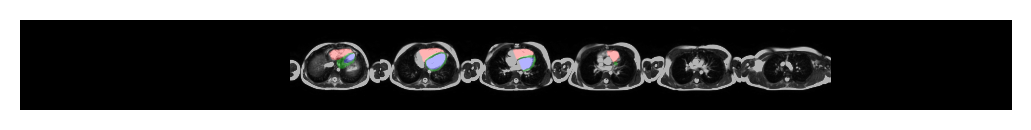

2020-12-17 20:05:14,702 INFO GT on AX


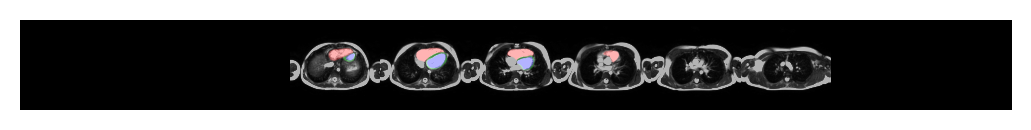

2020-12-17 20:05:15,292 INFO inv mask shape: (16, 256, 256, 4), gt mask shape: (16, 256, 256, 4)
2020-12-17 20:05:15,298 INFO DICE LV: 0.919671356678009
2020-12-17 20:05:15,304 INFO DICE RV: 0.8491034507751465
2020-12-17 20:05:15,309 INFO DICE MYO: 0.5532630085945129
2020-12-17 20:05:15,398 INFO m: [[ 0.4277 -0.847  -0.3162 -0.996 ]
 [ 0.3354 -0.176   0.926  -0.998 ]
 [-0.8394 -0.502   0.2087 13.06  ]]
2020-12-17 20:05:15,399 INFO m_mod: [[ 0.4277  -0.847   -0.3162   0.08203]
 [ 0.3354  -0.176    0.926   -0.3218 ]
 [-0.8394  -0.502    0.2087   0.566  ]]
2020-12-17 20:05:15,399 INFO m_scaled: [[ 0.4277 -0.847  -0.3162  0.1641]
 [ 0.3354 -0.176   0.926  -0.6436]
 [-0.8394 -0.502   0.2087  1.132 ]]
2020-12-17 20:05:15,400 INFO 0000-0PTV75MP_2005-06-27_ES_msk.nrrd
2020-12-17 20:05:20,899 INFO DICE LV: 0.8407816886901855
2020-12-17 20:05:20,996 INFO DICE RV: 0.8158069252967834
2020-12-17 20:05:21,092 INFO DICE MYO: 0.6763296723365784
2020-12-17 20:05:21,644 INFO Predicted mask rotated to AX

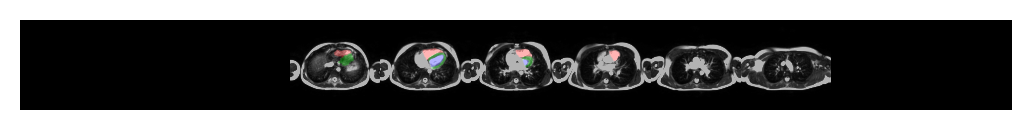

2020-12-17 20:05:22,114 INFO GT on AX


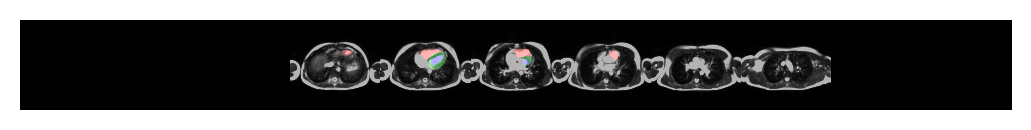

2020-12-17 20:05:22,693 INFO inv mask shape: (16, 256, 256, 4), gt mask shape: (16, 256, 256, 4)
2020-12-17 20:05:22,699 INFO DICE LV: 0.8758205771446228
2020-12-17 20:05:22,705 INFO DICE RV: 0.8342795372009277
2020-12-17 20:05:22,711 INFO DICE MYO: 0.6778608560562134
2020-12-17 20:05:22,796 INFO m: [[ 0.4272 -0.846  -0.3179 -0.996 ]
 [ 0.3357 -0.1779  0.925  -0.998 ]
 [-0.8394 -0.502   0.2081 13.08  ]]
2020-12-17 20:05:22,797 INFO m_mod: [[ 0.4272  -0.846   -0.3179   0.08215]
 [ 0.3357  -0.1779   0.925   -0.3223 ]
 [-0.8394  -0.502    0.2081   0.567  ]]
2020-12-17 20:05:22,797 INFO m_scaled: [[ 0.4272 -0.846  -0.3179  0.1643]
 [ 0.3357 -0.1779  0.925  -0.6445]
 [-0.8394 -0.502   0.2081  1.134 ]]
2020-12-17 20:05:22,798 INFO 0000-0RPELLU8_2007-02-13_ED_msk.nrrd
2020-12-17 20:05:28,238 INFO DICE LV: 0.9259113669395447
2020-12-17 20:05:28,332 INFO DICE RV: 0.8112394213676453
2020-12-17 20:05:28,433 INFO DICE MYO: 0.6758087277412415
2020-12-17 20:05:28,989 INFO Predicted mask rotated to A

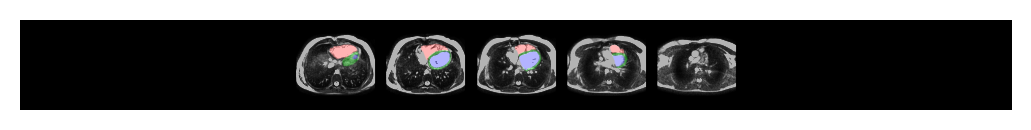

2020-12-17 20:05:29,449 INFO GT on AX


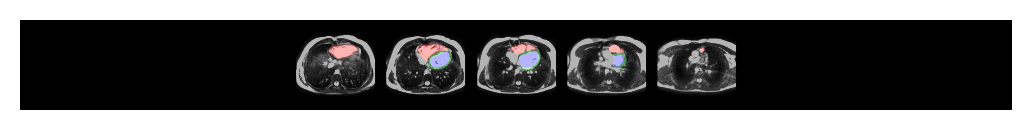

2020-12-17 20:05:29,962 INFO inv mask shape: (20, 288, 288, 4), gt mask shape: (20, 288, 288, 4)
2020-12-17 20:05:29,969 INFO DICE LV: 0.9264208674430847
2020-12-17 20:05:29,975 INFO DICE RV: 0.8064848780632019
2020-12-17 20:05:29,982 INFO DICE MYO: 0.6553583145141602
2020-12-17 20:05:30,067 INFO m: [[ 0.4302 -0.854  -0.292  -0.9956]
 [ 0.3328 -0.1504  0.931  -0.9976]
 [-0.839  -0.4978  0.2195 12.81  ]]
2020-12-17 20:05:30,068 INFO m_mod: [[ 0.4302  -0.854   -0.292    0.08044]
 [ 0.3328  -0.1504   0.931   -0.317  ]
 [-0.839   -0.4978   0.2195   0.555  ]]
2020-12-17 20:05:30,069 INFO m_scaled: [[ 0.4302 -0.854  -0.292   0.1609]
 [ 0.3328 -0.1504  0.931  -0.634 ]
 [-0.839  -0.4978  0.2195  1.11  ]]
2020-12-17 20:05:30,070 INFO 0000-0RPELLU8_2007-02-13_ES_msk.nrrd
2020-12-17 20:05:35,648 INFO DICE LV: 0.7872827053070068
2020-12-17 20:05:35,737 INFO DICE RV: 0.7109005451202393
2020-12-17 20:05:35,825 INFO DICE MYO: 0.7082644701004028
2020-12-17 20:05:36,382 INFO Predicted mask rotated to A

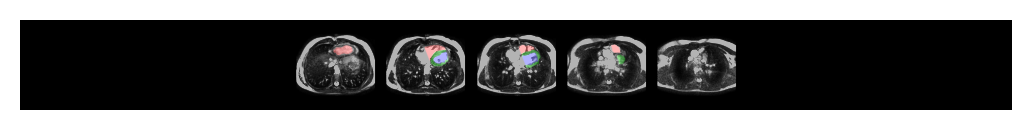

2020-12-17 20:05:36,838 INFO GT on AX


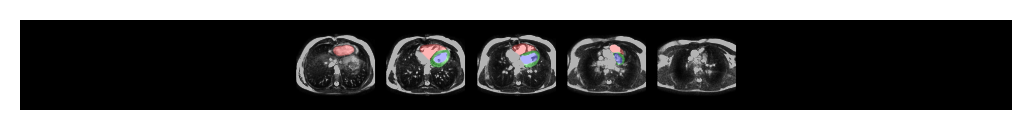

2020-12-17 20:05:37,350 INFO inv mask shape: (20, 288, 288, 4), gt mask shape: (20, 288, 288, 4)
2020-12-17 20:05:37,357 INFO DICE LV: 0.7986562252044678
2020-12-17 20:05:37,363 INFO DICE RV: 0.7443149089813232
2020-12-17 20:05:37,370 INFO DICE MYO: 0.7191216945648193
2020-12-17 20:05:37,451 INFO m: [[ 0.432  -0.8594 -0.2744 -0.9956]
 [ 0.331  -0.1318  0.9346 -0.9976]
 [-0.839  -0.4944  0.2273 12.65  ]]
2020-12-17 20:05:37,452 INFO m_mod: [[ 0.432  -0.8594 -0.2744  0.0794]
 [ 0.331  -0.1318  0.9346 -0.3135]
 [-0.839  -0.4944  0.2273  0.548 ]]
2020-12-17 20:05:37,452 INFO m_scaled: [[ 0.432  -0.8594 -0.2744  0.1588]
 [ 0.331  -0.1318  0.9346 -0.627 ]
 [-0.839  -0.4944  0.2273  1.096 ]]
2020-12-17 20:05:37,454 INFO 0000-2HQVK81W_2005-03-11_ED_msk.nrrd
2020-12-17 20:05:42,867 INFO DICE LV: 0.9158782362937927
2020-12-17 20:05:42,962 INFO DICE RV: 0.8817461133003235
2020-12-17 20:05:43,055 INFO DICE MYO: 0.6906399726867676
2020-12-17 20:05:43,623 INFO Predicted mask rotated to AX on origina

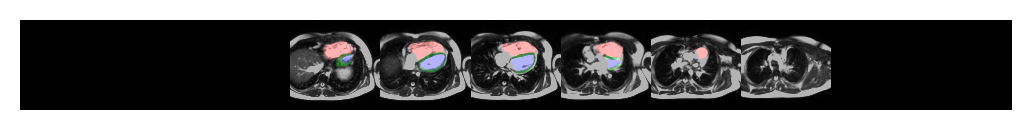

2020-12-17 20:05:44,088 INFO GT on AX


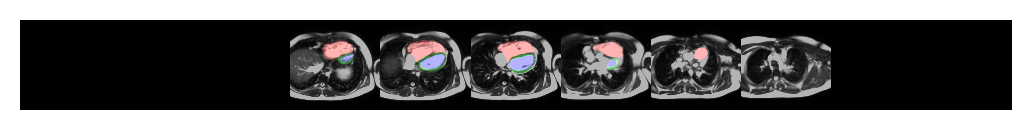

2020-12-17 20:05:44,666 INFO inv mask shape: (16, 256, 256, 4), gt mask shape: (16, 256, 256, 4)
2020-12-17 20:05:44,672 INFO DICE LV: 0.9300673007965088
2020-12-17 20:05:44,677 INFO DICE RV: 0.8969383835792542
2020-12-17 20:05:44,682 INFO DICE MYO: 0.709084153175354
2020-12-17 20:05:44,765 INFO m: [[ 0.4158 -0.799  -0.4346 -0.9976]
 [ 0.3484 -0.3018  0.8877 -0.999 ]
 [-0.8403 -0.5205  0.1528 14.234 ]]
2020-12-17 20:05:44,766 INFO m_mod: [[ 0.4158 -0.799  -0.4346  0.0893]
 [ 0.3484 -0.3018  0.8877 -0.3452]
 [-0.8403 -0.5205  0.1528  0.6167]]
2020-12-17 20:05:44,766 INFO m_scaled: [[ 0.4158 -0.799  -0.4346  0.1786]
 [ 0.3484 -0.3018  0.8877 -0.6904]
 [-0.8403 -0.5205  0.1528  1.233 ]]
2020-12-17 20:05:44,768 INFO 0000-2HQVK81W_2005-03-11_ES_msk.nrrd
2020-12-17 20:05:50,263 INFO DICE LV: 0.793585479259491
2020-12-17 20:05:50,359 INFO DICE RV: 0.7860977649688721
2020-12-17 20:05:50,466 INFO DICE MYO: 0.7405334115028381
2020-12-17 20:05:51,051 INFO Predicted mask rotated to AX on original 

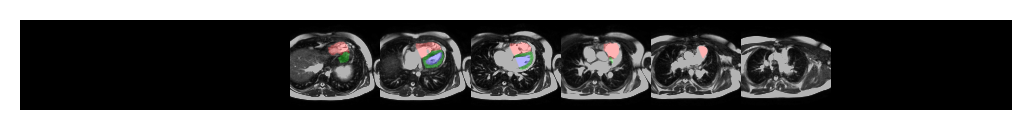

2020-12-17 20:05:51,529 INFO GT on AX


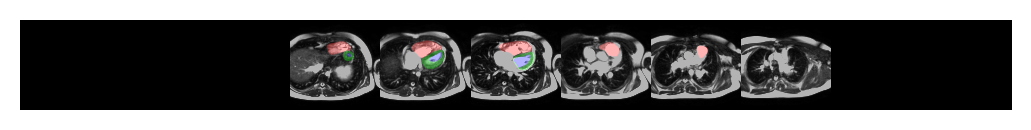

2020-12-17 20:05:53,113 INFO inv mask shape: (16, 256, 256, 4), gt mask shape: (16, 256, 256, 4)
2020-12-17 20:05:53,119 INFO DICE LV: 0.8200807571411133
2020-12-17 20:05:53,124 INFO DICE RV: 0.807878315448761
2020-12-17 20:05:53,129 INFO DICE MYO: 0.7532899975776672
2020-12-17 20:05:53,198 INFO m: [[ 0.417  -0.8037 -0.4248 -0.9976]
 [ 0.347  -0.2913  0.8916 -0.9985]
 [-0.8403 -0.519   0.1575 14.14  ]]
2020-12-17 20:05:53,198 INFO m_mod: [[ 0.417  -0.8037 -0.4248  0.0887]
 [ 0.347  -0.2913  0.8916 -0.3433]
 [-0.8403 -0.519   0.1575  0.6123]]
2020-12-17 20:05:53,199 INFO m_scaled: [[ 0.417  -0.8037 -0.4248  0.1774]
 [ 0.347  -0.2913  0.8916 -0.6865]
 [-0.8403 -0.519   0.1575  1.225 ]]
2020-12-17 20:05:53,200 INFO 0000-3E8U83K5_2006-04-01_ED_msk.nrrd
2020-12-17 20:05:58,865 INFO DICE LV: 0.8646475076675415
2020-12-17 20:05:58,949 INFO DICE RV: 0.8058230876922607
2020-12-17 20:05:59,034 INFO DICE MYO: 0.6831792593002319
2020-12-17 20:05:59,590 INFO Predicted mask rotated to AX on original

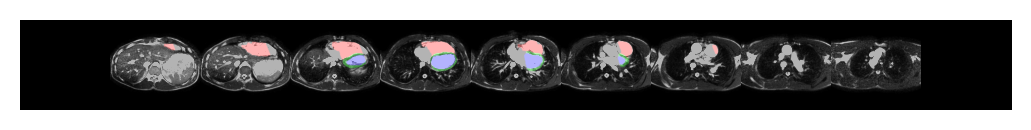

2020-12-17 20:06:00,079 INFO GT on AX


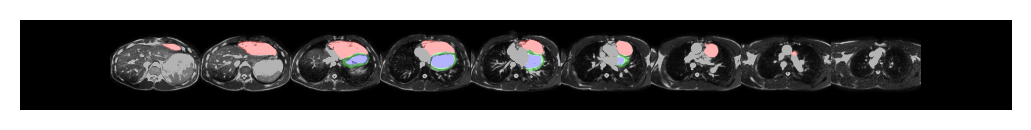

2020-12-17 20:06:00,801 INFO inv mask shape: (36, 256, 256, 4), gt mask shape: (36, 256, 256, 4)
2020-12-17 20:06:00,812 INFO DICE LV: 0.8523522019386292
2020-12-17 20:06:00,822 INFO DICE RV: 0.8094125390052795
2020-12-17 20:06:00,833 INFO DICE MYO: 0.6789734363555908
2020-12-17 20:06:00,922 INFO m: [[ 0.42   -0.8164 -0.3967 -0.9976]
 [ 0.3442 -0.2615  0.902  -0.9985]
 [-0.84   -0.5156  0.1713 13.84  ]]
2020-12-17 20:06:00,923 INFO m_mod: [[ 0.42    -0.8164  -0.3967   0.08685]
 [ 0.3442  -0.2615   0.902   -0.3374 ]
 [-0.84    -0.5156   0.1713   0.599  ]]
2020-12-17 20:06:00,923 INFO m_scaled: [[ 0.42   -0.8164 -0.3967  0.1737]
 [ 0.3442 -0.2615  0.902  -0.675 ]
 [-0.84   -0.5156  0.1713  1.198 ]]
2020-12-17 20:06:00,924 INFO 0000-3E8U83K5_2006-04-01_ES_msk.nrrd
2020-12-17 20:06:06,481 INFO DICE LV: 0.8570109605789185
2020-12-17 20:06:06,566 INFO DICE RV: 0.7176697254180908
2020-12-17 20:06:06,654 INFO DICE MYO: 0.7669606804847717
2020-12-17 20:06:07,183 INFO Predicted mask rotated to A

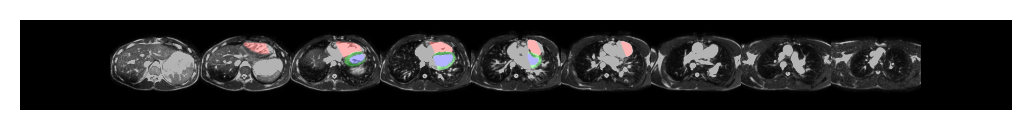

2020-12-17 20:06:07,670 INFO GT on AX


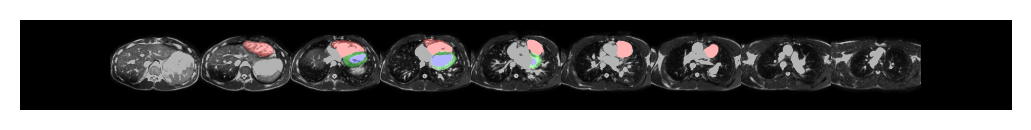

2020-12-17 20:06:08,333 INFO inv mask shape: (36, 256, 256, 4), gt mask shape: (36, 256, 256, 4)
2020-12-17 20:06:08,345 INFO DICE LV: 0.8670664429664612
2020-12-17 20:06:08,357 INFO DICE RV: 0.7197690010070801
2020-12-17 20:06:08,367 INFO DICE MYO: 0.7666197419166565
2020-12-17 20:06:08,445 INFO m: [[ 0.42   -0.8164 -0.3967 -0.9976]
 [ 0.3442 -0.2615  0.902  -0.9985]
 [-0.84   -0.5156  0.1713 13.84  ]]
2020-12-17 20:06:08,446 INFO m_mod: [[ 0.42    -0.8164  -0.3967   0.08685]
 [ 0.3442  -0.2615   0.902   -0.3374 ]
 [-0.84    -0.5156   0.1713   0.599  ]]
2020-12-17 20:06:08,446 INFO m_scaled: [[ 0.42   -0.8164 -0.3967  0.1737]
 [ 0.3442 -0.2615  0.902  -0.675 ]
 [-0.84   -0.5156  0.1713  1.198 ]]
2020-12-17 20:06:08,447 INFO 0000-3E90836W_2006-05-23_ED_msk.nrrd
2020-12-17 20:06:13,855 INFO DICE LV: 0.8171141147613525
2020-12-17 20:06:13,946 INFO DICE RV: 0.740086019039154
2020-12-17 20:06:14,036 INFO DICE MYO: 0.5345147252082825
2020-12-17 20:06:14,602 INFO Predicted mask rotated to AX

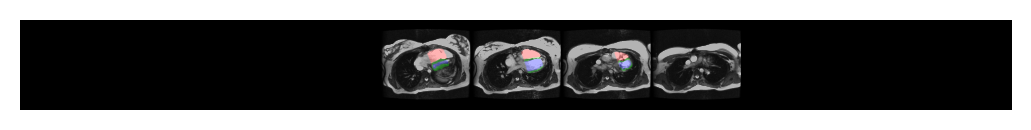

2020-12-17 20:06:15,081 INFO GT on AX


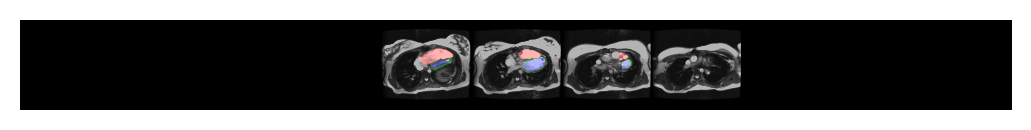

2020-12-17 20:06:15,696 INFO inv mask shape: (17, 512, 512, 4), gt mask shape: (17, 512, 512, 4)
2020-12-17 20:06:15,714 INFO DICE LV: 0.8072882890701294
2020-12-17 20:06:15,732 INFO DICE RV: 0.7499038577079773
2020-12-17 20:06:15,751 INFO DICE MYO: 0.5320973992347717
2020-12-17 20:06:15,837 INFO m: [[ 0.4272 -0.845  -0.3196 -0.996 ]
 [ 0.3357 -0.1797  0.9243 -0.998 ]
 [-0.8394 -0.5024  0.2072 13.09  ]]
2020-12-17 20:06:15,838 INFO m_mod: [[ 0.4272 -0.845  -0.3196  0.0823]
 [ 0.3357 -0.1797  0.9243 -0.3228]
 [-0.8394 -0.5024  0.2072  0.5674]]
2020-12-17 20:06:15,839 INFO m_scaled: [[ 0.4272 -0.845  -0.3196  0.1646]
 [ 0.3357 -0.1797  0.9243 -0.6455]
 [-0.8394 -0.5024  0.2072  1.135 ]]
2020-12-17 20:06:15,843 INFO 0000-3E90836W_2006-05-23_ES_msk.nrrd
2020-12-17 20:06:21,163 INFO DICE LV: 0.7654736042022705
2020-12-17 20:06:21,251 INFO DICE RV: 0.6972987055778503
2020-12-17 20:06:21,339 INFO DICE MYO: 0.6568726897239685
2020-12-17 20:06:21,896 INFO Predicted mask rotated to AX on origina

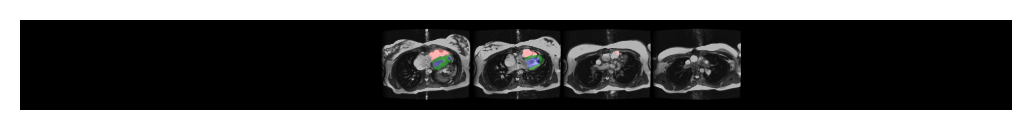

2020-12-17 20:06:22,354 INFO GT on AX


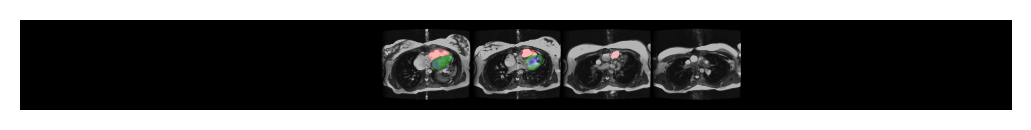

2020-12-17 20:06:22,949 INFO inv mask shape: (17, 512, 512, 4), gt mask shape: (17, 512, 512, 4)
2020-12-17 20:06:22,967 INFO DICE LV: 0.789834201335907
2020-12-17 20:06:22,984 INFO DICE RV: 0.7800976037979126
2020-12-17 20:06:23,000 INFO DICE MYO: 0.6888172030448914
2020-12-17 20:06:23,084 INFO m: [[ 0.4282 -0.849  -0.3093 -0.996 ]
 [ 0.3347 -0.1691  0.9272 -0.998 ]
 [-0.8394 -0.5005  0.2117 12.99  ]]
2020-12-17 20:06:23,085 INFO m_mod: [[ 0.4282 -0.849  -0.3093  0.0816]
 [ 0.3347 -0.1691  0.9272 -0.3203]
 [-0.8394 -0.5005  0.2117  0.563 ]]
2020-12-17 20:06:23,085 INFO m_scaled: [[ 0.4282 -0.849  -0.3093  0.1632]
 [ 0.3347 -0.1691  0.9272 -0.6406]
 [-0.8394 -0.5005  0.2117  1.126 ]]
2020-12-17 20:06:23,089 INFO 0000-3HQQHA3N_2006-03-01_ED_msk.nrrd
2020-12-17 20:06:28,498 INFO DICE LV: 0.8207759261131287
2020-12-17 20:06:28,593 INFO DICE RV: 0.5418895483016968
2020-12-17 20:06:28,689 INFO DICE MYO: 0.61801677942276
2020-12-17 20:06:29,253 INFO Predicted mask rotated to AX on original A

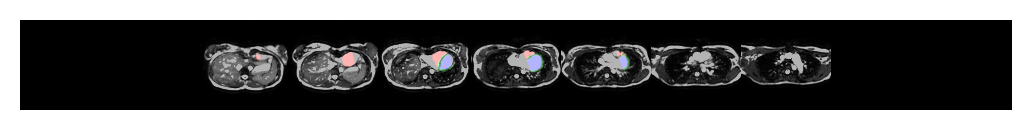

2020-12-17 20:06:29,724 INFO GT on AX


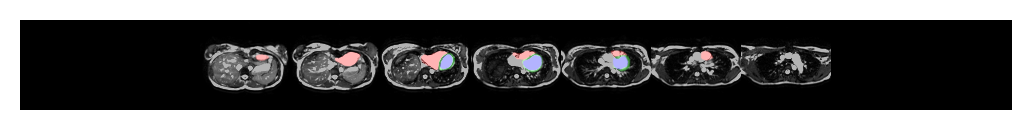

2020-12-17 20:06:30,340 INFO inv mask shape: (26, 256, 256, 4), gt mask shape: (26, 256, 256, 4)
2020-12-17 20:06:30,347 INFO DICE LV: 0.8164597749710083
2020-12-17 20:06:30,354 INFO DICE RV: 0.5396563410758972
2020-12-17 20:06:30,360 INFO DICE MYO: 0.6090456247329712
2020-12-17 20:06:30,446 INFO m: [[ 0.4277 -0.847  -0.3162 -0.996 ]
 [ 0.3354 -0.176   0.926  -0.998 ]
 [-0.8394 -0.502   0.2087 13.055 ]]
2020-12-17 20:06:30,447 INFO m_mod: [[ 0.4277 -0.847  -0.3162  0.082 ]
 [ 0.3354 -0.176   0.926  -0.3218]
 [-0.8394 -0.502   0.2087  0.5654]]
2020-12-17 20:06:30,448 INFO m_scaled: [[ 0.4277 -0.847  -0.3162  0.164 ]
 [ 0.3354 -0.176   0.926  -0.6436]
 [-0.8394 -0.502   0.2087  1.131 ]]
2020-12-17 20:06:30,448 INFO 0000-3HQQHA3N_2006-03-01_ES_msk.nrrd
2020-12-17 20:06:35,790 INFO DICE LV: 0.8446370363235474
2020-12-17 20:06:35,878 INFO DICE RV: 0.5516518950462341
2020-12-17 20:06:35,965 INFO DICE MYO: 0.6977273225784302
2020-12-17 20:06:36,512 INFO Predicted mask rotated to AX on origina

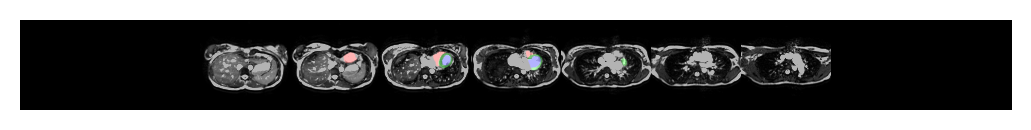

2020-12-17 20:06:36,973 INFO GT on AX


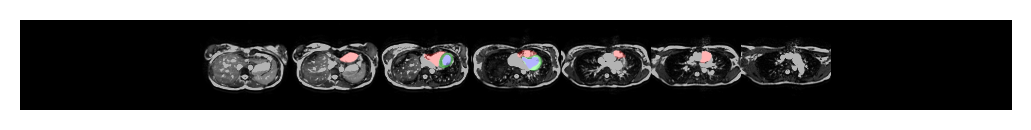

2020-12-17 20:06:37,556 INFO inv mask shape: (26, 256, 256, 4), gt mask shape: (26, 256, 256, 4)
2020-12-17 20:06:37,564 INFO DICE LV: 0.8471486568450928
2020-12-17 20:06:37,572 INFO DICE RV: 0.5525026321411133
2020-12-17 20:06:37,580 INFO DICE MYO: 0.7022098302841187
2020-12-17 20:06:37,663 INFO m: [[ 0.4287 -0.8516 -0.3008 -0.996 ]
 [ 0.3335 -0.16    0.9287 -0.9976]
 [-0.8394 -0.4988  0.2155 12.914 ]]
2020-12-17 20:06:37,663 INFO m_mod: [[ 0.4287 -0.8516 -0.3008  0.0811]
 [ 0.3335 -0.16    0.9287 -0.3188]
 [-0.8394 -0.4988  0.2155  0.5596]]
2020-12-17 20:06:37,664 INFO m_scaled: [[ 0.4287 -0.8516 -0.3008  0.1622]
 [ 0.3335 -0.16    0.9287 -0.6377]
 [-0.8394 -0.4988  0.2155  1.119 ]]
2020-12-17 20:06:37,665 INFO 0000-4EUFPCDM_2007-01-15_ED_msk.nrrd
2020-12-17 20:06:42,999 INFO DICE LV: 0.8937117457389832
2020-12-17 20:06:43,086 INFO DICE RV: 0.7827490568161011
2020-12-17 20:06:43,174 INFO DICE MYO: 0.5690686106681824
2020-12-17 20:06:43,730 INFO Predicted mask rotated to AX on origina

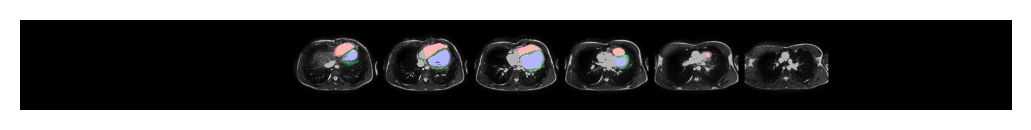

2020-12-17 20:06:44,193 INFO GT on AX


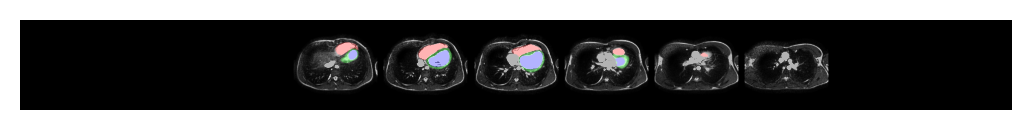

2020-12-17 20:06:44,703 INFO inv mask shape: (16, 288, 288, 4), gt mask shape: (16, 288, 288, 4)
2020-12-17 20:06:44,711 INFO DICE LV: 0.9043759703636169
2020-12-17 20:06:44,718 INFO DICE RV: 0.7926657795906067
2020-12-17 20:06:44,724 INFO DICE MYO: 0.5756697654724121
2020-12-17 20:06:44,809 INFO m: [[ 0.4304 -0.8555 -0.2878 -0.9956]
 [ 0.3325 -0.146   0.9316 -0.9976]
 [-0.839  -0.4966  0.2216 12.79  ]]
2020-12-17 20:06:44,809 INFO m_mod: [[ 0.4304 -0.8555 -0.2878  0.0804]
 [ 0.3325 -0.146   0.9316 -0.3164]
 [-0.839  -0.4966  0.2216  0.554 ]]
2020-12-17 20:06:44,810 INFO m_scaled: [[ 0.4304 -0.8555 -0.2878  0.1608]
 [ 0.3325 -0.146   0.9316 -0.633 ]
 [-0.839  -0.4966  0.2216  1.108 ]]
2020-12-17 20:06:44,811 INFO 0000-4EUFPCDM_2007-01-15_ES_msk.nrrd
2020-12-17 20:06:50,121 INFO DICE LV: 0.8118910193443298
2020-12-17 20:06:50,216 INFO DICE RV: 0.72348952293396
2020-12-17 20:06:50,310 INFO DICE MYO: 0.592856228351593
2020-12-17 20:06:50,868 INFO Predicted mask rotated to AX on original A

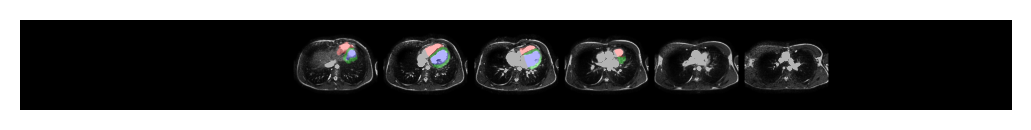

2020-12-17 20:06:51,330 INFO GT on AX


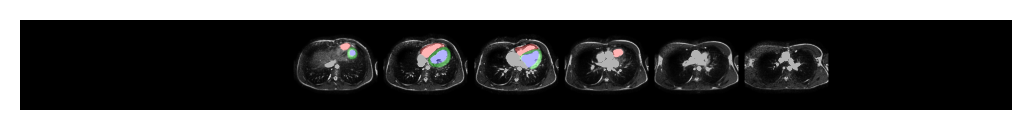

2020-12-17 20:06:51,878 INFO inv mask shape: (16, 288, 288, 4), gt mask shape: (16, 288, 288, 4)
2020-12-17 20:06:51,885 INFO DICE LV: 0.8327769637107849
2020-12-17 20:06:51,891 INFO DICE RV: 0.7319921255111694
2020-12-17 20:06:51,898 INFO DICE MYO: 0.6143488883972168
2020-12-17 20:06:51,986 INFO m: [[ 0.4312 -0.857  -0.2832 -0.9956]
 [ 0.332  -0.1411  0.9326 -0.9976]
 [-0.839  -0.4958  0.2235 12.75  ]]
2020-12-17 20:06:51,986 INFO m_mod: [[ 0.4312  -0.857   -0.2832   0.08014]
 [ 0.332   -0.1411   0.9326  -0.3154 ]
 [-0.839   -0.4958   0.2235   0.5522 ]]
2020-12-17 20:06:51,987 INFO m_scaled: [[ 0.4312 -0.857  -0.2832  0.1603]
 [ 0.332  -0.1411  0.9326 -0.631 ]
 [-0.839  -0.4958  0.2235  1.1045]]
2020-12-17 20:06:51,988 INFO 0000-5T8DXCQ2_2006-10-01_ED_msk.nrrd
2020-12-17 20:06:57,277 INFO DICE LV: 0.9178812503814697
2020-12-17 20:06:57,365 INFO DICE RV: 0.8310158848762512
2020-12-17 20:06:57,460 INFO DICE MYO: 0.6546457409858704
2020-12-17 20:06:58,014 INFO Predicted mask rotated to A

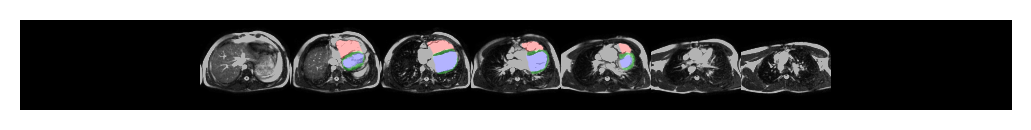

2020-12-17 20:06:58,481 INFO GT on AX


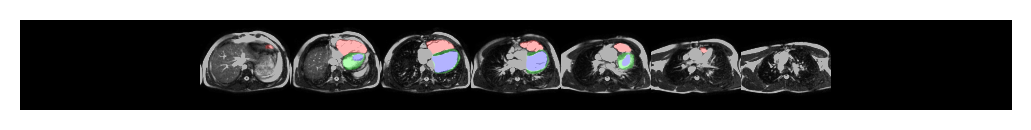

2020-12-17 20:06:59,078 INFO inv mask shape: (26, 256, 256, 4), gt mask shape: (26, 256, 256, 4)
2020-12-17 20:06:59,086 INFO DICE LV: 0.9230960011482239
2020-12-17 20:06:59,094 INFO DICE RV: 0.8246391415596008
2020-12-17 20:06:59,102 INFO DICE MYO: 0.6601195335388184
2020-12-17 20:06:59,189 INFO m: [[ 0.418  -0.8086 -0.4146 -0.9976]
 [ 0.346  -0.2805  0.8955 -0.9985]
 [-0.8403 -0.5176  0.1625 14.04  ]]
2020-12-17 20:06:59,190 INFO m_mod: [[ 0.418  -0.8086 -0.4146  0.088 ]
 [ 0.346  -0.2805  0.8955 -0.3413]
 [-0.8403 -0.5176  0.1625  0.608 ]]
2020-12-17 20:06:59,190 INFO m_scaled: [[ 0.418  -0.8086 -0.4146  0.176 ]
 [ 0.346  -0.2805  0.8955 -0.6826]
 [-0.8403 -0.5176  0.1625  1.216 ]]
2020-12-17 20:06:59,192 INFO 0000-5T8DXCQ2_2006-10-01_ES_msk.nrrd
2020-12-17 20:07:04,465 INFO DICE LV: 0.8549081087112427
2020-12-17 20:07:04,561 INFO DICE RV: 0.6986078023910522
2020-12-17 20:07:04,656 INFO DICE MYO: 0.6293675303459167
2020-12-17 20:07:05,213 INFO Predicted mask rotated to AX on origina

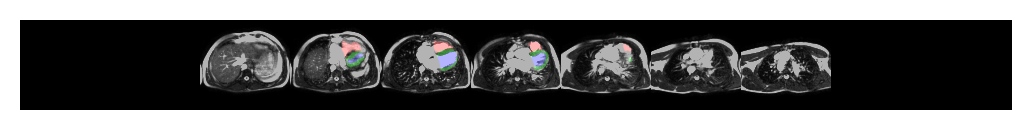

2020-12-17 20:07:05,681 INFO GT on AX


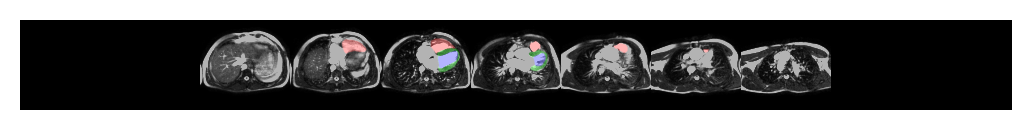

2020-12-17 20:07:07,360 INFO inv mask shape: (26, 256, 256, 4), gt mask shape: (26, 256, 256, 4)
2020-12-17 20:07:07,368 INFO DICE LV: 0.8665006756782532
2020-12-17 20:07:07,374 INFO DICE RV: 0.7042654156684875
2020-12-17 20:07:07,381 INFO DICE MYO: 0.6302400231361389
2020-12-17 20:07:07,449 INFO m: [[ 0.4202 -0.8184 -0.3918 -0.997 ]
 [ 0.3438 -0.256   0.9033 -0.9985]
 [-0.84   -0.514   0.1738 13.8   ]]
2020-12-17 20:07:07,450 INFO m_mod: [[ 0.4202  -0.8184  -0.3918   0.08655]
 [ 0.3438  -0.256    0.9033  -0.3364 ]
 [-0.84    -0.514    0.1738   0.5977 ]]
2020-12-17 20:07:07,450 INFO m_scaled: [[ 0.4202 -0.8184 -0.3918  0.1731]
 [ 0.3438 -0.256   0.9033 -0.673 ]
 [-0.84   -0.514   0.1738  1.195 ]]
2020-12-17 20:07:07,452 INFO 0000-84R7FQH3_2007-03-16_ED_msk.nrrd
2020-12-17 20:07:12,965 INFO DICE LV: 0.9073357582092285
2020-12-17 20:07:13,049 INFO DICE RV: 0.8201335072517395
2020-12-17 20:07:13,133 INFO DICE MYO: 0.6131959557533264
2020-12-17 20:07:13,684 INFO Predicted mask rotated to A

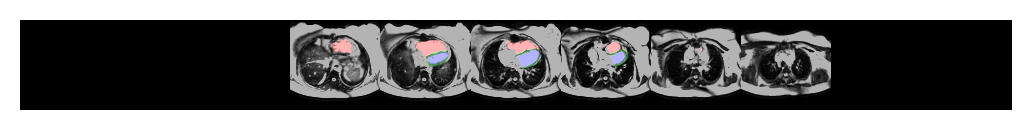

2020-12-17 20:07:14,155 INFO GT on AX


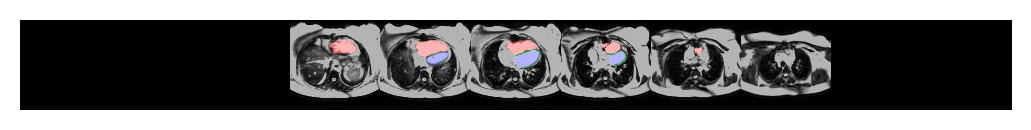

2020-12-17 20:07:14,675 INFO inv mask shape: (23, 256, 256, 4), gt mask shape: (23, 256, 256, 4)
2020-12-17 20:07:14,682 INFO DICE LV: 0.9148682951927185
2020-12-17 20:07:14,688 INFO DICE RV: 0.8360247611999512
2020-12-17 20:07:14,694 INFO DICE MYO: 0.6070225834846497
2020-12-17 20:07:14,777 INFO m: [[ 0.4106 -0.7695 -0.4885 -0.998 ]
 [ 0.3535 -0.3594  0.8633 -0.999 ]
 [-0.8403 -0.5273  0.1246 14.8   ]]
2020-12-17 20:07:14,777 INFO m_mod: [[ 0.4106 -0.7695 -0.4885  0.0927]
 [ 0.3535 -0.3594  0.8633 -0.3564]
 [-0.8403 -0.5273  0.1246  0.64  ]]
2020-12-17 20:07:14,778 INFO m_scaled: [[ 0.4106 -0.7695 -0.4885  0.1854]
 [ 0.3535 -0.3594  0.8633 -0.713 ]
 [-0.8403 -0.5273  0.1246  1.28  ]]
2020-12-17 20:07:14,779 INFO 0000-84R7FQH3_2007-03-16_ES_msk.nrrd
2020-12-17 20:07:20,196 INFO DICE LV: 0.8679899573326111
2020-12-17 20:07:20,270 INFO DICE RV: 0.8033811450004578
2020-12-17 20:07:20,342 INFO DICE MYO: 0.7347981333732605
2020-12-17 20:07:20,873 INFO Predicted mask rotated to AX on origina

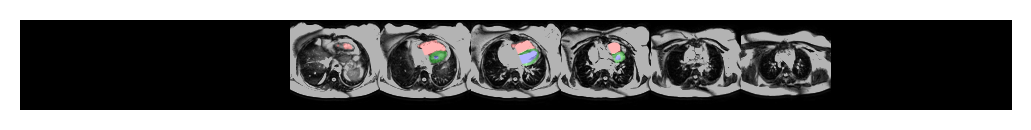

2020-12-17 20:07:21,346 INFO GT on AX


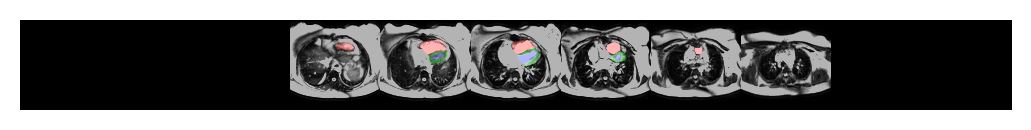

2020-12-17 20:07:21,869 INFO inv mask shape: (23, 256, 256, 4), gt mask shape: (23, 256, 256, 4)
2020-12-17 20:07:21,876 INFO DICE LV: 0.8806912899017334
2020-12-17 20:07:21,883 INFO DICE RV: 0.8238689303398132
2020-12-17 20:07:21,890 INFO DICE MYO: 0.7418516278266907
2020-12-17 20:07:21,958 INFO m: [[ 0.4106 -0.7705 -0.4868 -0.998 ]
 [ 0.3535 -0.3577  0.8643 -0.999 ]
 [-0.8403 -0.5273  0.1256 14.78  ]]
2020-12-17 20:07:21,959 INFO m_mod: [[ 0.4106  -0.7705  -0.4868   0.09265]
 [ 0.3535  -0.3577   0.8643  -0.356  ]
 [-0.8403  -0.5273   0.1256   0.6396 ]]
2020-12-17 20:07:21,960 INFO m_scaled: [[ 0.4106 -0.7705 -0.4868  0.1853]
 [ 0.3535 -0.3577  0.8643 -0.712 ]
 [-0.8403 -0.5273  0.1256  1.279 ]]
2020-12-17 20:07:21,961 INFO 0000-DG1U4JUW_2006-12-22_ED_msk.nrrd
2020-12-17 20:07:27,288 INFO DICE LV: 0.9337422847747803
2020-12-17 20:07:27,377 INFO DICE RV: 0.7639768123626709
2020-12-17 20:07:27,465 INFO DICE MYO: 0.6942844986915588
2020-12-17 20:07:27,991 INFO Predicted mask rotated to A

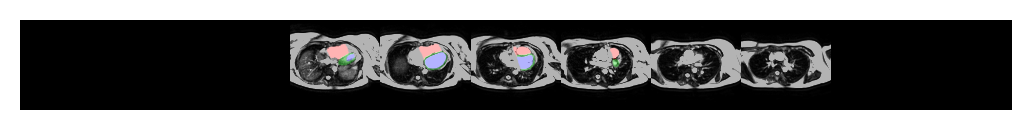

2020-12-17 20:07:28,463 INFO GT on AX


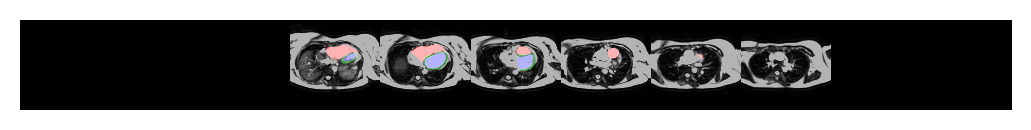

2020-12-17 20:07:28,995 INFO inv mask shape: (23, 256, 256, 4), gt mask shape: (23, 256, 256, 4)
2020-12-17 20:07:29,002 INFO DICE LV: 0.9401476383209229
2020-12-17 20:07:29,009 INFO DICE RV: 0.7656822800636292
2020-12-17 20:07:29,016 INFO DICE MYO: 0.6941271424293518
2020-12-17 20:07:29,103 INFO m: [[ 0.4182 -0.8105 -0.4104 -0.9976]
 [ 0.3455 -0.2761  0.897  -0.9985]
 [-0.8403 -0.517   0.1646 13.984 ]]
2020-12-17 20:07:29,104 INFO m_mod: [[ 0.4182 -0.8105 -0.4104  0.0877]
 [ 0.3455 -0.2761  0.897  -0.3403]
 [-0.8403 -0.517   0.1646  0.6055]]
2020-12-17 20:07:29,104 INFO m_scaled: [[ 0.4182 -0.8105 -0.4104  0.1754]
 [ 0.3455 -0.2761  0.897  -0.6807]
 [-0.8403 -0.517   0.1646  1.211 ]]
2020-12-17 20:07:29,105 INFO 0000-DG1U4JUW_2006-12-22_ES_msk.nrrd
2020-12-17 20:07:34,460 INFO DICE LV: 0.8562390208244324
2020-12-17 20:07:34,534 INFO DICE RV: 0.7442053556442261
2020-12-17 20:07:34,606 INFO DICE MYO: 0.7608785629272461
2020-12-17 20:07:35,135 INFO Predicted mask rotated to AX on origina

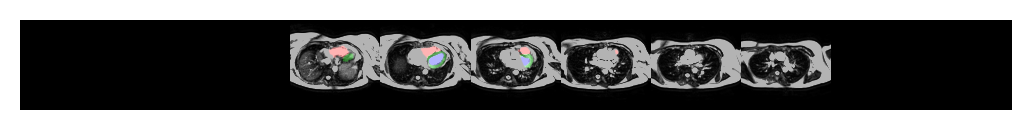

2020-12-17 20:07:35,599 INFO GT on AX


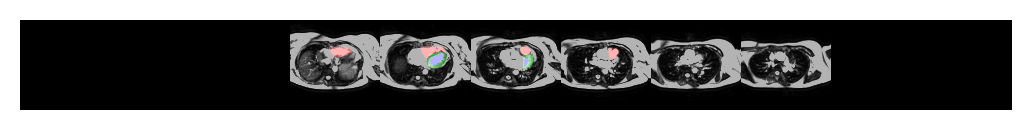

2020-12-17 20:07:36,105 INFO inv mask shape: (23, 256, 256, 4), gt mask shape: (23, 256, 256, 4)
2020-12-17 20:07:36,113 INFO DICE LV: 0.8594777584075928
2020-12-17 20:07:36,120 INFO DICE RV: 0.761077880859375
2020-12-17 20:07:36,127 INFO DICE MYO: 0.7581714391708374
2020-12-17 20:07:36,197 INFO m: [[ 0.42   -0.817  -0.3958 -0.997 ]
 [ 0.3442 -0.2605  0.9023 -0.9985]
 [-0.84   -0.515   0.1716 13.836 ]]
2020-12-17 20:07:36,197 INFO m_mod: [[ 0.42   -0.817  -0.3958  0.0868]
 [ 0.3442 -0.2605  0.9023 -0.3374]
 [-0.84   -0.515   0.1716  0.599 ]]
2020-12-17 20:07:36,198 INFO m_scaled: [[ 0.42   -0.817  -0.3958  0.1736]
 [ 0.3442 -0.2605  0.9023 -0.675 ]
 [-0.84   -0.515   0.1716  1.198 ]]
2020-12-17 20:07:36,199 INFO 0000-DHQPDW6M_2007-02-16_ED_msk.nrrd
2020-12-17 20:07:41,460 INFO DICE LV: 0.8930341005325317
2020-12-17 20:07:41,548 INFO DICE RV: 0.8225684762001038
2020-12-17 20:07:41,636 INFO DICE MYO: 0.6830267906188965
2020-12-17 20:07:42,194 INFO Predicted mask rotated to AX on original

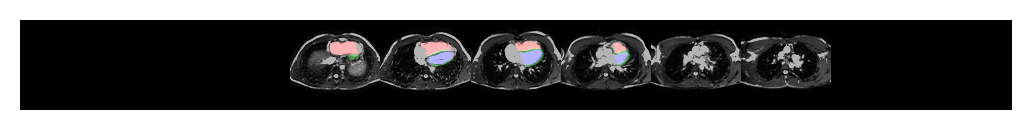

2020-12-17 20:07:42,656 INFO GT on AX


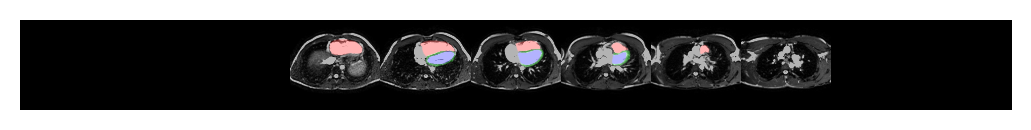

2020-12-17 20:07:43,233 INFO inv mask shape: (24, 256, 256, 4), gt mask shape: (24, 256, 256, 4)
2020-12-17 20:07:43,241 INFO DICE LV: 0.8979405760765076
2020-12-17 20:07:43,249 INFO DICE RV: 0.8309458494186401
2020-12-17 20:07:43,256 INFO DICE MYO: 0.6766725778579712
2020-12-17 20:07:43,340 INFO m: [[ 0.4272 -0.8457 -0.3188 -0.996 ]
 [ 0.3357 -0.1788  0.925  -0.998 ]
 [-0.8394 -0.5024  0.2076 13.08  ]]
2020-12-17 20:07:43,341 INFO m_mod: [[ 0.4272 -0.8457 -0.3188  0.0821]
 [ 0.3357 -0.1788  0.925  -0.3223]
 [-0.8394 -0.5024  0.2076  0.5664]]
2020-12-17 20:07:43,341 INFO m_scaled: [[ 0.4272 -0.8457 -0.3188  0.1642]
 [ 0.3357 -0.1788  0.925  -0.6445]
 [-0.8394 -0.5024  0.2076  1.133 ]]
2020-12-17 20:07:43,342 INFO 0000-DHQPDW6M_2007-02-16_ES_msk.nrrd
2020-12-17 20:07:48,599 INFO DICE LV: 0.8074049949645996
2020-12-17 20:07:48,688 INFO DICE RV: 0.6983276605606079
2020-12-17 20:07:48,777 INFO DICE MYO: 0.6902230381965637
2020-12-17 20:07:49,351 INFO Predicted mask rotated to AX on origina

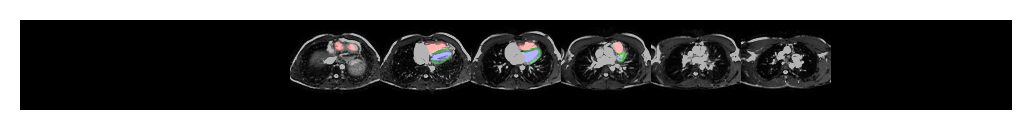

2020-12-17 20:07:49,819 INFO GT on AX


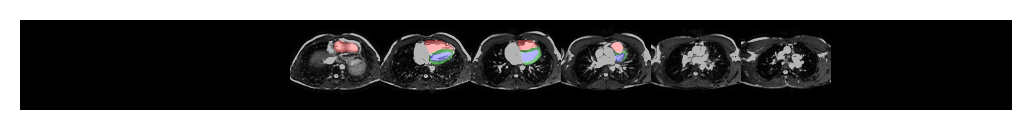

2020-12-17 20:07:50,386 INFO inv mask shape: (24, 256, 256, 4), gt mask shape: (24, 256, 256, 4)
2020-12-17 20:07:50,394 INFO DICE LV: 0.8307543992996216
2020-12-17 20:07:50,400 INFO DICE RV: 0.7238904237747192
2020-12-17 20:07:50,406 INFO DICE MYO: 0.6956114768981934
2020-12-17 20:07:50,493 INFO m: [[ 0.4304 -0.856  -0.2866 -0.9956]
 [ 0.3323 -0.1449  0.932  -0.9976]
 [-0.839  -0.4966  0.222  12.77  ]]
2020-12-17 20:07:50,494 INFO m_mod: [[ 0.4304  -0.856   -0.2866   0.08026]
 [ 0.3323  -0.1449   0.932   -0.316  ]
 [-0.839   -0.4966   0.222    0.5537 ]]
2020-12-17 20:07:50,494 INFO m_scaled: [[ 0.4304 -0.856  -0.2866  0.1605]
 [ 0.3323 -0.1449  0.932  -0.632 ]
 [-0.839  -0.4966  0.222   1.107 ]]
2020-12-17 20:07:50,495 INFO 0000-E4YTNGAZ_2006-11-07_ED_msk.nrrd
2020-12-17 20:07:55,807 INFO DICE LV: 0.933875560760498
2020-12-17 20:07:55,905 INFO DICE RV: 0.8229743242263794
2020-12-17 20:07:56,001 INFO DICE MYO: 0.6878772974014282
2020-12-17 20:07:56,562 INFO Predicted mask rotated to AX

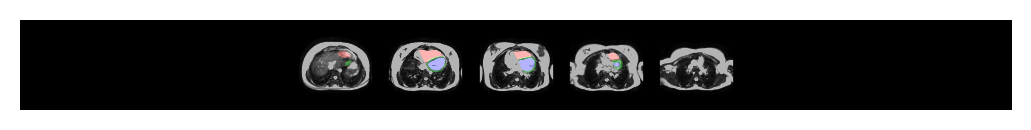

2020-12-17 20:07:57,019 INFO GT on AX


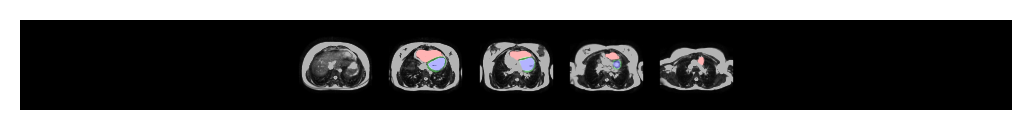

2020-12-17 20:07:57,505 INFO inv mask shape: (18, 288, 288, 4), gt mask shape: (18, 288, 288, 4)
2020-12-17 20:07:57,512 INFO DICE LV: 0.941668689250946
2020-12-17 20:07:57,519 INFO DICE RV: 0.8265423774719238
2020-12-17 20:07:57,526 INFO DICE MYO: 0.6852161884307861
2020-12-17 20:07:57,614 INFO m: [[ 0.427  -0.844  -0.3232 -0.9966]
 [ 0.3362 -0.1833  0.924  -0.998 ]
 [-0.8394 -0.503   0.2057 13.12  ]]
2020-12-17 20:07:57,615 INFO m_mod: [[ 0.427  -0.844  -0.3232  0.0824]
 [ 0.3362 -0.1833  0.924  -0.3232]
 [-0.8394 -0.503   0.2057  0.5684]]
2020-12-17 20:07:57,615 INFO m_scaled: [[ 0.427  -0.844  -0.3232  0.1648]
 [ 0.3362 -0.1833  0.924  -0.6465]
 [-0.8394 -0.503   0.2057  1.137 ]]
2020-12-17 20:07:57,616 INFO 0000-E4YTNGAZ_2006-11-07_ES_msk.nrrd
2020-12-17 20:08:02,884 INFO DICE LV: 0.8931900262832642
2020-12-17 20:08:02,973 INFO DICE RV: 0.8044084906578064
2020-12-17 20:08:03,062 INFO DICE MYO: 0.7283821702003479
2020-12-17 20:08:03,622 INFO Predicted mask rotated to AX on original

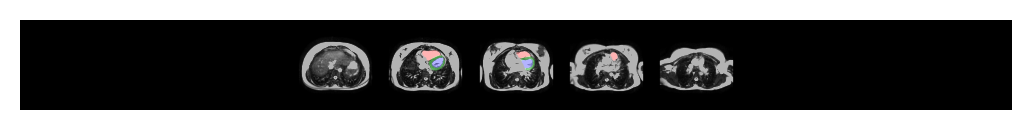

2020-12-17 20:08:04,090 INFO GT on AX


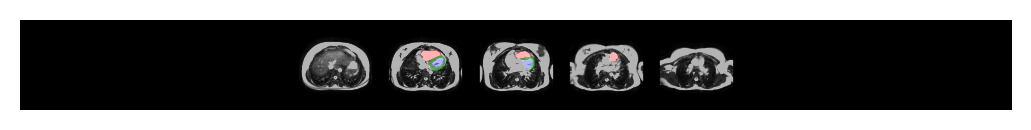

2020-12-17 20:08:04,592 INFO inv mask shape: (18, 288, 288, 4), gt mask shape: (18, 288, 288, 4)
2020-12-17 20:08:04,600 INFO DICE LV: 0.891946017742157
2020-12-17 20:08:04,607 INFO DICE RV: 0.8229198455810547
2020-12-17 20:08:04,613 INFO DICE MYO: 0.7339426875114441
2020-12-17 20:08:04,698 INFO m: [[ 0.4277 -0.8477 -0.3147 -0.996 ]
 [ 0.3354 -0.1743  0.9263 -0.998 ]
 [-0.8394 -0.5015  0.2096 13.03  ]]
2020-12-17 20:08:04,699 INFO m_mod: [[ 0.4277  -0.8477  -0.3147   0.08185]
 [ 0.3354  -0.1743   0.9263  -0.3213 ]
 [-0.8394  -0.5015   0.2096   0.5645 ]]
2020-12-17 20:08:04,699 INFO m_scaled: [[ 0.4277 -0.8477 -0.3147  0.1637]
 [ 0.3354 -0.1743  0.9263 -0.6426]
 [-0.8394 -0.5015  0.2096  1.129 ]]
2020-12-17 20:08:04,700 INFO 0000-ER5Q2EXD_2007-02-22_ED_msk.nrrd
2020-12-17 20:08:09,992 INFO DICE LV: 0.8728203177452087
2020-12-17 20:08:10,086 INFO DICE RV: 0.7548416256904602
2020-12-17 20:08:10,174 INFO DICE MYO: 0.5209516882896423
2020-12-17 20:08:10,733 INFO Predicted mask rotated to AX

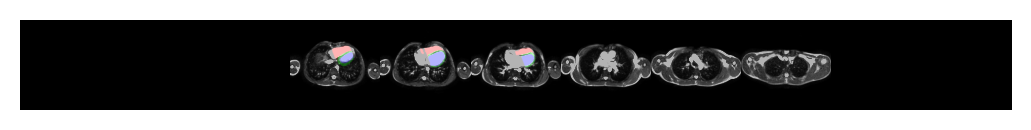

2020-12-17 20:08:11,194 INFO GT on AX


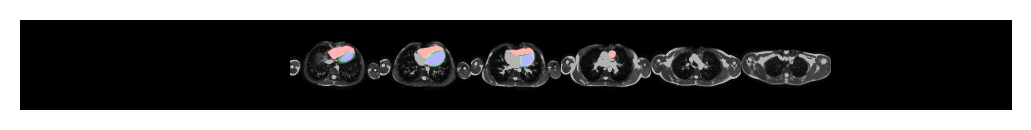

2020-12-17 20:08:11,798 INFO inv mask shape: (26, 256, 256, 4), gt mask shape: (26, 256, 256, 4)
2020-12-17 20:08:11,807 INFO DICE LV: 0.8784307837486267
2020-12-17 20:08:11,815 INFO DICE RV: 0.7366822361946106
2020-12-17 20:08:11,824 INFO DICE MYO: 0.5229707360267639
2020-12-17 20:08:11,909 INFO m: [[ 0.4285 -0.851  -0.3037 -0.996 ]
 [ 0.334  -0.163   0.928  -0.998 ]
 [-0.8394 -0.4995  0.2146 12.94  ]]
2020-12-17 20:08:11,909 INFO m_mod: [[ 0.4285 -0.851  -0.3037  0.0813]
 [ 0.334  -0.163   0.928  -0.3193]
 [-0.8394 -0.4995  0.2146  0.5605]]
2020-12-17 20:08:11,910 INFO m_scaled: [[ 0.4285 -0.851  -0.3037  0.1626]
 [ 0.334  -0.163   0.928  -0.6387]
 [-0.8394 -0.4995  0.2146  1.121 ]]
2020-12-17 20:08:11,911 INFO 0000-ER5Q2EXD_2007-02-22_ES_msk.nrrd
2020-12-17 20:08:17,156 INFO DICE LV: 0.8500139713287354
2020-12-17 20:08:17,245 INFO DICE RV: 0.6508955359458923
2020-12-17 20:08:17,333 INFO DICE MYO: 0.6461114287376404
2020-12-17 20:08:17,888 INFO Predicted mask rotated to AX on origina

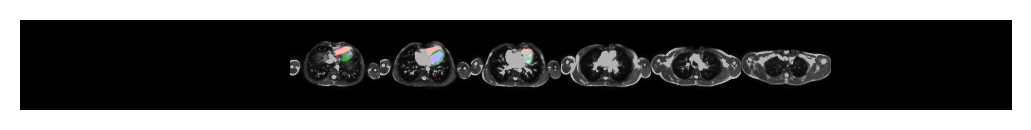

2020-12-17 20:08:18,351 INFO GT on AX


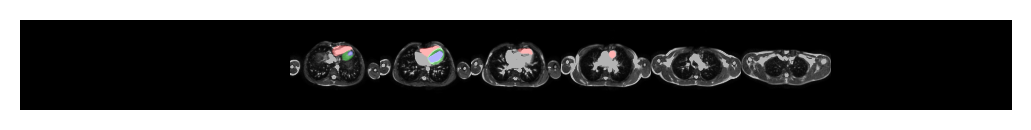

2020-12-17 20:08:18,953 INFO inv mask shape: (26, 256, 256, 4), gt mask shape: (26, 256, 256, 4)
2020-12-17 20:08:18,961 INFO DICE LV: 0.8637920022010803
2020-12-17 20:08:18,969 INFO DICE RV: 0.6380945444107056
2020-12-17 20:08:18,976 INFO DICE MYO: 0.6540104150772095
2020-12-17 20:08:19,063 INFO m: [[ 0.4285 -0.8506 -0.3042 -0.996 ]
 [ 0.334  -0.1637  0.9277 -0.998 ]
 [-0.8394 -0.4995  0.214  12.95  ]]
2020-12-17 20:08:19,063 INFO m_mod: [[ 0.4285  -0.8506  -0.3042   0.08136]
 [ 0.334   -0.1637   0.9277  -0.3193 ]
 [-0.8394  -0.4995   0.214    0.561  ]]
2020-12-17 20:08:19,064 INFO m_scaled: [[ 0.4285 -0.8506 -0.3042  0.1627]
 [ 0.334  -0.1637  0.9277 -0.6387]
 [-0.8394 -0.4995  0.214   1.122 ]]
2020-12-17 20:08:19,065 INFO 0000-F0QP6ZJR_2006-01-01_ED_msk.nrrd
2020-12-17 20:08:25,810 INFO DICE LV: 0.921075165271759
2020-12-17 20:08:25,892 INFO DICE RV: 0.7452598810195923
2020-12-17 20:08:25,973 INFO DICE MYO: 0.7091942429542542
2020-12-17 20:08:26,508 INFO Predicted mask rotated to AX

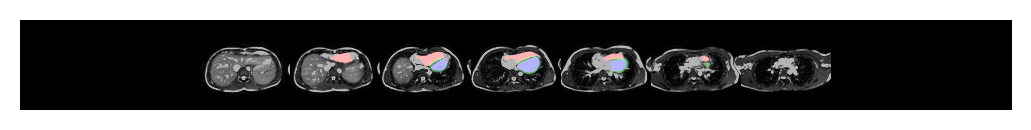

2020-12-17 20:08:26,975 INFO GT on AX


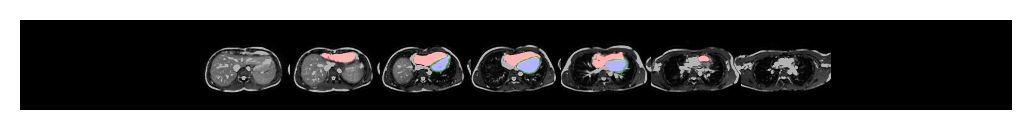

2020-12-17 20:08:27,515 INFO inv mask shape: (26, 256, 256, 4), gt mask shape: (26, 256, 256, 4)
2020-12-17 20:08:27,523 INFO DICE LV: 0.9234901070594788
2020-12-17 20:08:27,531 INFO DICE RV: 0.752749502658844
2020-12-17 20:08:27,539 INFO DICE MYO: 0.7106391787528992
2020-12-17 20:08:27,618 INFO m: [[ 0.427  -0.845  -0.3213 -0.996 ]
 [ 0.3362 -0.1815  0.9243 -0.998 ]
 [-0.8394 -0.5024  0.2067 13.1   ]]
2020-12-17 20:08:27,619 INFO m_mod: [[ 0.427  -0.845  -0.3213  0.0823]
 [ 0.3362 -0.1815  0.9243 -0.3228]
 [-0.8394 -0.5024  0.2067  0.5674]]
2020-12-17 20:08:27,620 INFO m_scaled: [[ 0.427  -0.845  -0.3213  0.1646]
 [ 0.3362 -0.1815  0.9243 -0.6455]
 [-0.8394 -0.5024  0.2067  1.135 ]]
2020-12-17 20:08:27,620 INFO 0000-F0QP6ZJR_2006-01-01_ES_msk.nrrd
2020-12-17 20:08:33,037 INFO DICE LV: 0.8708360195159912
2020-12-17 20:08:33,119 INFO DICE RV: 0.6887180209159851
2020-12-17 20:08:33,200 INFO DICE MYO: 0.7488555908203125
2020-12-17 20:08:33,725 INFO Predicted mask rotated to AX on original

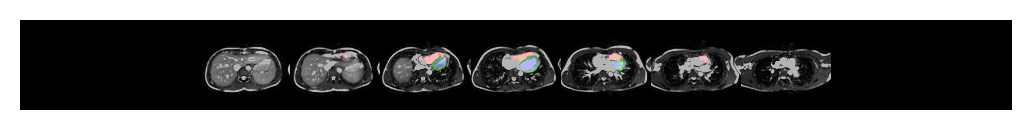

2020-12-17 20:08:34,216 INFO GT on AX


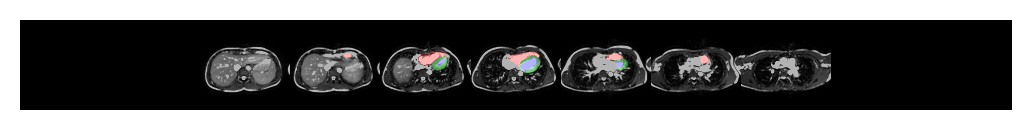

2020-12-17 20:08:34,758 INFO inv mask shape: (26, 256, 256, 4), gt mask shape: (26, 256, 256, 4)
2020-12-17 20:08:34,766 INFO DICE LV: 0.8731057047843933
2020-12-17 20:08:34,774 INFO DICE RV: 0.7103259563446045
2020-12-17 20:08:34,782 INFO DICE MYO: 0.7534042596817017
2020-12-17 20:08:34,859 INFO m: [[ 0.428  -0.848  -0.312  -0.996 ]
 [ 0.335  -0.1718  0.9263 -0.998 ]
 [-0.8394 -0.501   0.2106 13.02  ]]
2020-12-17 20:08:34,860 INFO m_mod: [[ 0.428  -0.848  -0.312   0.0818]
 [ 0.335  -0.1718  0.9263 -0.3213]
 [-0.8394 -0.501   0.2106  0.564 ]]
2020-12-17 20:08:34,860 INFO m_scaled: [[ 0.428  -0.848  -0.312   0.1636]
 [ 0.335  -0.1718  0.9263 -0.6426]
 [-0.8394 -0.501   0.2106  1.128 ]]
2020-12-17 20:08:34,861 INFO 0000-JERK6VC0_2006-01-19_ED_msk.nrrd
2020-12-17 20:08:40,204 INFO DICE LV: 0.6967328786849976
2020-12-17 20:08:40,293 INFO DICE RV: 0.7247313857078552
2020-12-17 20:08:40,382 INFO DICE MYO: 0.44667086005210876
2020-12-17 20:08:40,920 INFO Predicted mask rotated to AX on origin

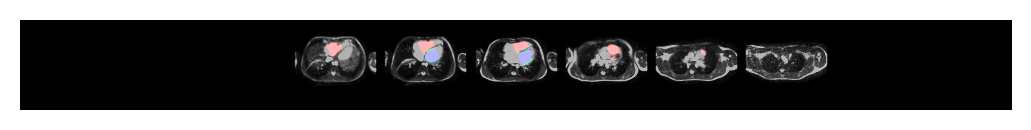

2020-12-17 20:08:41,385 INFO GT on AX


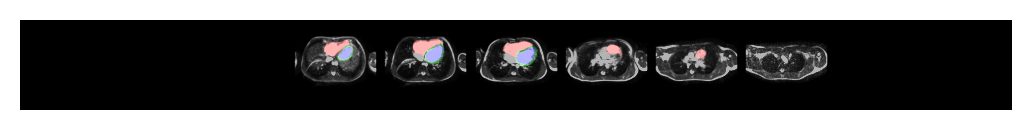

2020-12-17 20:08:41,895 INFO inv mask shape: (22, 256, 256, 4), gt mask shape: (22, 256, 256, 4)
2020-12-17 20:08:41,902 INFO DICE LV: 0.6961508989334106
2020-12-17 20:08:41,908 INFO DICE RV: 0.7093790173530579
2020-12-17 20:08:41,915 INFO DICE MYO: 0.44952085614204407
2020-12-17 20:08:42,000 INFO m: [[ 0.4297 -0.853  -0.2969 -0.996 ]
 [ 0.3335 -0.1555  0.93   -0.9976]
 [-0.839  -0.4985  0.2177 12.875 ]]
2020-12-17 20:08:42,000 INFO m_mod: [[ 0.4297 -0.853  -0.2969  0.0808]
 [ 0.3335 -0.1555  0.93   -0.3179]
 [-0.839  -0.4985  0.2177  0.5576]]
2020-12-17 20:08:42,001 INFO m_scaled: [[ 0.4297 -0.853  -0.2969  0.1616]
 [ 0.3335 -0.1555  0.93   -0.6357]
 [-0.839  -0.4985  0.2177  1.115 ]]
2020-12-17 20:08:42,002 INFO 0000-JERK6VC0_2006-01-19_ES_msk.nrrd
2020-12-17 20:08:47,250 INFO DICE LV: 0.7029768824577332
2020-12-17 20:08:47,333 INFO DICE RV: 0.716864824295044
2020-12-17 20:08:47,414 INFO DICE MYO: 0.4435969889163971
2020-12-17 20:08:47,943 INFO Predicted mask rotated to AX on origina

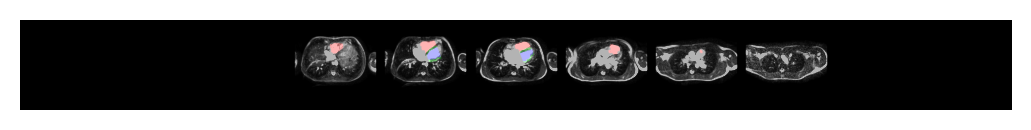

2020-12-17 20:08:48,408 INFO GT on AX


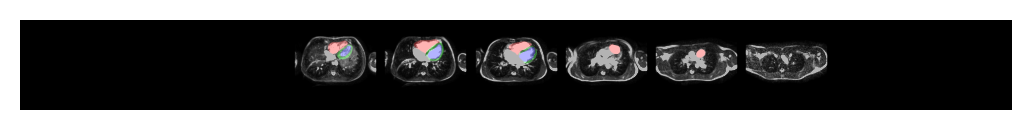

2020-12-17 20:08:48,916 INFO inv mask shape: (22, 256, 256, 4), gt mask shape: (22, 256, 256, 4)
2020-12-17 20:08:48,924 INFO DICE LV: 0.6843339204788208
2020-12-17 20:08:48,931 INFO DICE RV: 0.7453092336654663
2020-12-17 20:08:48,937 INFO DICE MYO: 0.4328837990760803
2020-12-17 20:08:49,014 INFO m: [[ 0.4302 -0.8545 -0.291  -0.9956]
 [ 0.3328 -0.1493  0.931  -0.9976]
 [-0.839  -0.4976  0.2201 12.82  ]]
2020-12-17 20:08:49,015 INFO m_mod: [[ 0.4302 -0.8545 -0.291   0.0805]
 [ 0.3328 -0.1493  0.931  -0.317 ]
 [-0.839  -0.4976  0.2201  0.555 ]]
2020-12-17 20:08:49,015 INFO m_scaled: [[ 0.4302 -0.8545 -0.291   0.161 ]
 [ 0.3328 -0.1493  0.931  -0.634 ]
 [-0.839  -0.4976  0.2201  1.11  ]]
2020-12-17 20:08:49,016 INFO 0000-K5T17122_2005-08-25_ED_msk.nrrd
2020-12-17 20:08:54,258 INFO DICE LV: 0.8338661193847656
2020-12-17 20:08:54,347 INFO DICE RV: 0.5281968712806702
2020-12-17 20:08:54,435 INFO DICE MYO: 0.49434715509414673
2020-12-17 20:08:54,959 INFO Predicted mask rotated to AX on origin

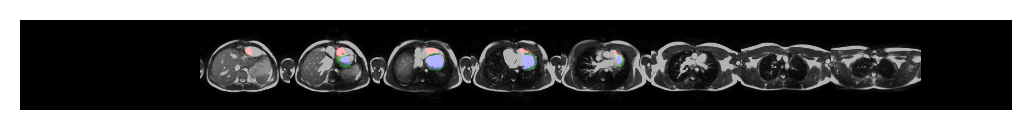

2020-12-17 20:08:55,422 INFO GT on AX


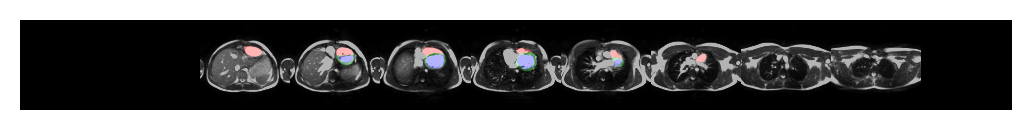

2020-12-17 20:08:56,000 INFO inv mask shape: (22, 256, 256, 4), gt mask shape: (22, 256, 256, 4)
2020-12-17 20:08:56,007 INFO DICE LV: 0.8496009707450867
2020-12-17 20:08:56,014 INFO DICE RV: 0.5418344140052795
2020-12-17 20:08:56,020 INFO DICE MYO: 0.5198417901992798
2020-12-17 20:08:56,104 INFO m: [[ 0.4182 -0.8115 -0.4087 -0.9976]
 [ 0.3455 -0.2742  0.8975 -0.9985]
 [-0.8403 -0.5166  0.1655 13.97  ]]
2020-12-17 20:08:56,104 INFO m_mod: [[ 0.4182  -0.8115  -0.4087   0.08765]
 [ 0.3455  -0.2742   0.8975  -0.3403 ]
 [-0.8403  -0.5166   0.1655   0.6055 ]]
2020-12-17 20:08:56,105 INFO m_scaled: [[ 0.4182 -0.8115 -0.4087  0.1753]
 [ 0.3455 -0.2742  0.8975 -0.6807]
 [-0.8403 -0.5166  0.1655  1.211 ]]
2020-12-17 20:08:56,106 INFO 0000-K5T17122_2005-08-25_ES_msk.nrrd
2020-12-17 20:09:01,375 INFO DICE LV: 0.7332366704940796
2020-12-17 20:09:01,464 INFO DICE RV: 0.370327353477478
2020-12-17 20:09:01,552 INFO DICE MYO: 0.5410771369934082
2020-12-17 20:09:02,123 INFO Predicted mask rotated to AX

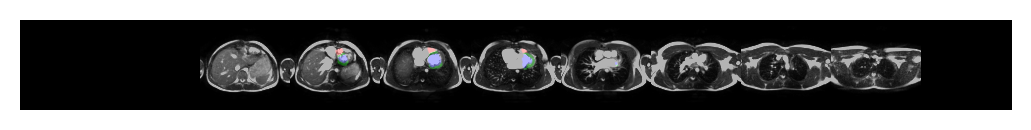

2020-12-17 20:09:02,596 INFO GT on AX


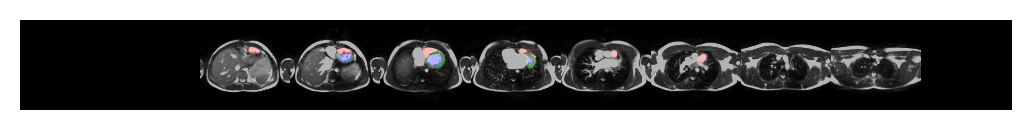

2020-12-17 20:09:03,208 INFO inv mask shape: (22, 256, 256, 4), gt mask shape: (22, 256, 256, 4)
2020-12-17 20:09:03,215 INFO DICE LV: 0.7447428107261658
2020-12-17 20:09:03,222 INFO DICE RV: 0.3740205764770508
2020-12-17 20:09:03,229 INFO DICE MYO: 0.5531423687934875
2020-12-17 20:09:03,314 INFO m: [[ 0.418  -0.8096 -0.413  -0.9976]
 [ 0.346  -0.2788  0.896  -0.9985]
 [-0.8403 -0.517   0.1635 14.02  ]]
2020-12-17 20:09:03,315 INFO m_mod: [[ 0.418   -0.8096  -0.413    0.08795]
 [ 0.346   -0.2788   0.896   -0.3413 ]
 [-0.8403  -0.517    0.1635   0.6074 ]]
2020-12-17 20:09:03,315 INFO m_scaled: [[ 0.418  -0.8096 -0.413   0.1759]
 [ 0.346  -0.2788  0.896  -0.6826]
 [-0.8403 -0.517   0.1635  1.215 ]]
2020-12-17 20:09:03,316 INFO 0000-KHQNN842_2006-01-01_ED_msk.nrrd
2020-12-17 20:09:09,674 INFO DICE LV: 0.9166485071182251
2020-12-17 20:09:09,768 INFO DICE RV: 0.8337616920471191
2020-12-17 20:09:09,864 INFO DICE MYO: 0.5991251468658447
2020-12-17 20:09:10,420 INFO Predicted mask rotated to A

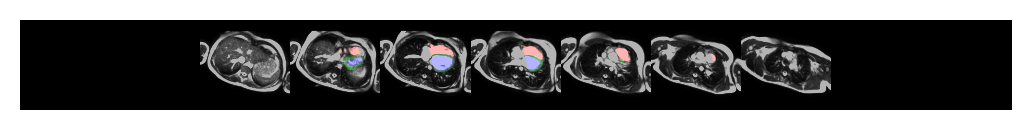

2020-12-17 20:09:10,881 INFO GT on AX


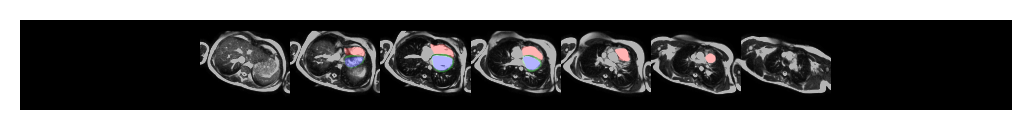

2020-12-17 20:09:11,481 INFO inv mask shape: (28, 256, 256, 4), gt mask shape: (28, 256, 256, 4)
2020-12-17 20:09:11,489 INFO DICE LV: 0.9257921576499939
2020-12-17 20:09:11,496 INFO DICE RV: 0.8309616446495056
2020-12-17 20:09:11,503 INFO DICE MYO: 0.608995258808136
2020-12-17 20:09:11,588 INFO m: [[ 0.4236 -0.8335 -0.3555 -0.9966]
 [ 0.3396 -0.2179  0.9155 -0.998 ]
 [-0.84   -0.5083  0.1908 13.445 ]]
2020-12-17 20:09:11,588 INFO m_mod: [[ 0.4236  -0.8335  -0.3555   0.08435]
 [ 0.3396  -0.2179   0.9155  -0.3296 ]
 [-0.84    -0.5083   0.1908   0.582  ]]
2020-12-17 20:09:11,589 INFO m_scaled: [[ 0.4236 -0.8335 -0.3555  0.1687]
 [ 0.3396 -0.2179  0.9155 -0.659 ]
 [-0.84   -0.5083  0.1908  1.164 ]]
2020-12-17 20:09:11,590 INFO 0000-KHQNN842_2006-01-01_ES_msk.nrrd
2020-12-17 20:09:16,835 INFO DICE LV: 0.8553036451339722
2020-12-17 20:09:16,924 INFO DICE RV: 0.8017541170120239
2020-12-17 20:09:17,012 INFO DICE MYO: 0.7070666551589966
2020-12-17 20:09:17,566 INFO Predicted mask rotated to AX

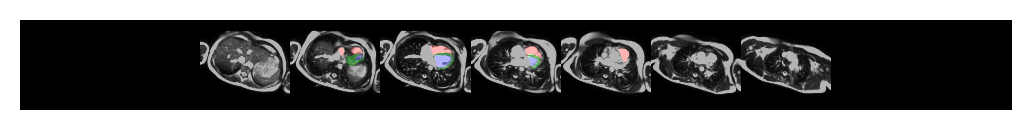

2020-12-17 20:09:18,030 INFO GT on AX


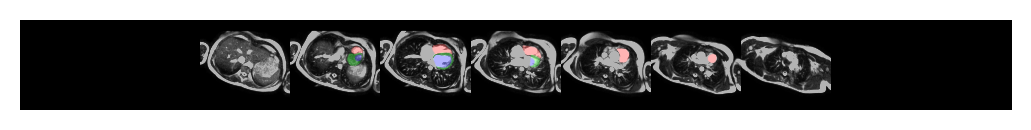

2020-12-17 20:09:18,632 INFO inv mask shape: (28, 256, 256, 4), gt mask shape: (28, 256, 256, 4)
2020-12-17 20:09:18,640 INFO DICE LV: 0.8665582537651062
2020-12-17 20:09:18,647 INFO DICE RV: 0.7983386516571045
2020-12-17 20:09:18,654 INFO DICE MYO: 0.7154197692871094
2020-12-17 20:09:18,742 INFO m: [[ 0.4229 -0.8306 -0.3623 -0.997 ]
 [ 0.3403 -0.2249  0.913  -0.9985]
 [-0.84   -0.51    0.1877 13.5   ]]
2020-12-17 20:09:18,742 INFO m_mod: [[ 0.4229 -0.8306 -0.3623  0.0847]
 [ 0.3403 -0.2249  0.913  -0.3306]
 [-0.84   -0.51    0.1877  0.5845]]
2020-12-17 20:09:18,743 INFO m_scaled: [[ 0.4229 -0.8306 -0.3623  0.1694]
 [ 0.3403 -0.2249  0.913  -0.661 ]
 [-0.84   -0.51    0.1877  1.169 ]]
2020-12-17 20:09:18,744 INFO 0000-LLLNJLF6_2006-09-27_ED_msk.nrrd
2020-12-17 20:09:24,063 INFO DICE LV: 0.8047893047332764
2020-12-17 20:09:24,158 INFO DICE RV: 0.7263398766517639
2020-12-17 20:09:24,253 INFO DICE MYO: 0.43001165986061096
2020-12-17 20:09:24,821 INFO Predicted mask rotated to AX on origin

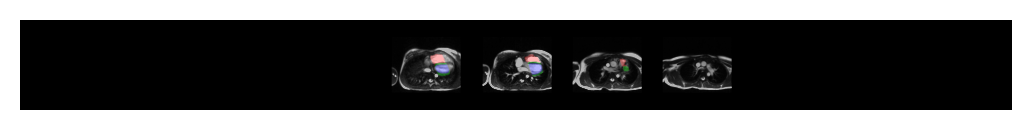

2020-12-17 20:09:25,286 INFO GT on AX


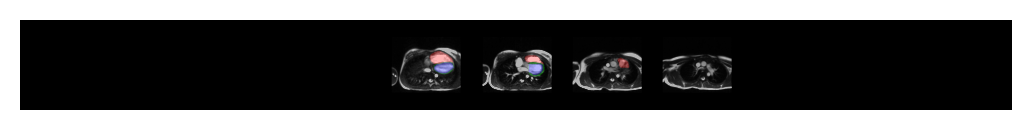

2020-12-17 20:09:25,750 INFO inv mask shape: (15, 156, 192, 4), gt mask shape: (15, 156, 192, 4)
2020-12-17 20:09:25,753 INFO DICE LV: 0.8084906935691833
2020-12-17 20:09:25,756 INFO DICE RV: 0.7429677844047546
2020-12-17 20:09:25,759 INFO DICE MYO: 0.42721277475357056
2020-12-17 20:09:25,843 INFO m: [[ 0.4355 -0.8667 -0.2415 -0.995 ]
 [ 0.3274 -0.0969  0.94   -0.997 ]
 [-0.8384 -0.4885  0.2416 12.36  ]]
2020-12-17 20:09:25,843 INFO m_mod: [[ 0.4355  -0.8667  -0.2415   0.07776]
 [ 0.3274  -0.0969   0.94    -0.3071 ]
 [-0.8384  -0.4885   0.2416   0.5356 ]]
2020-12-17 20:09:25,844 INFO m_scaled: [[ 0.4355 -0.8667 -0.2415  0.1555]
 [ 0.3274 -0.0969  0.94   -0.6143]
 [-0.8384 -0.4885  0.2416  1.071 ]]
2020-12-17 20:09:25,845 INFO 0000-LLLNJLF6_2006-09-27_ES_msk.nrrd
2020-12-17 20:09:31,144 INFO DICE LV: 0.7381384372711182
2020-12-17 20:09:31,238 INFO DICE RV: 0.7519987225532532
2020-12-17 20:09:31,326 INFO DICE MYO: 0.46309980750083923
2020-12-17 20:09:31,904 INFO Predicted mask rotated to

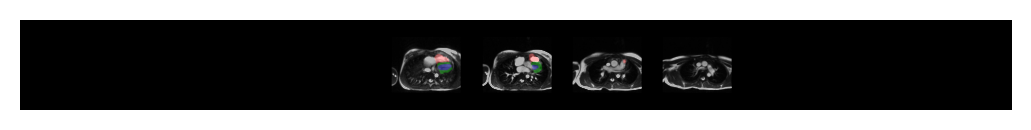

2020-12-17 20:09:32,364 INFO GT on AX


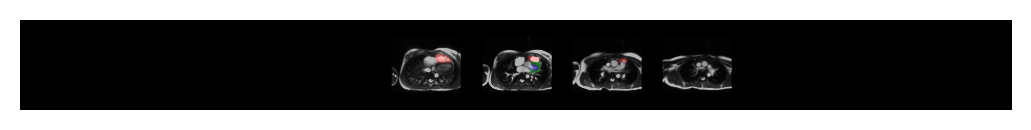

2020-12-17 20:09:32,834 INFO inv mask shape: (15, 156, 192, 4), gt mask shape: (15, 156, 192, 4)
2020-12-17 20:09:32,837 INFO DICE LV: 0.7758381366729736
2020-12-17 20:09:32,840 INFO DICE RV: 0.7589016556739807
2020-12-17 20:09:32,843 INFO DICE MYO: 0.44781816005706787
2020-12-17 20:09:32,924 INFO m: [[ 0.436   -0.868   -0.2356  -0.9946 ]
 [ 0.3267  -0.09106  0.9404  -0.997  ]
 [-0.8384  -0.4873   0.244   12.305  ]]
2020-12-17 20:09:32,925 INFO m_mod: [[ 0.436   -0.868   -0.2356   0.0774 ]
 [ 0.3267  -0.09106  0.9404  -0.3062 ]
 [-0.8384  -0.4873   0.244    0.533  ]]
2020-12-17 20:09:32,926 INFO m_scaled: [[ 0.436   -0.868   -0.2356   0.1548 ]
 [ 0.3267  -0.09106  0.9404  -0.6123 ]
 [-0.8384  -0.4873   0.244    1.066  ]]
2020-12-17 20:09:32,927 INFO 0000-LV70LENY_2007-03-12_ED_msk.nrrd
2020-12-17 20:09:38,310 INFO DICE LV: 0.8843879699707031
2020-12-17 20:09:38,400 INFO DICE RV: 0.8435144424438477
2020-12-17 20:09:38,487 INFO DICE MYO: 0.6687829494476318
2020-12-17 20:09:39,047 INFO Pr

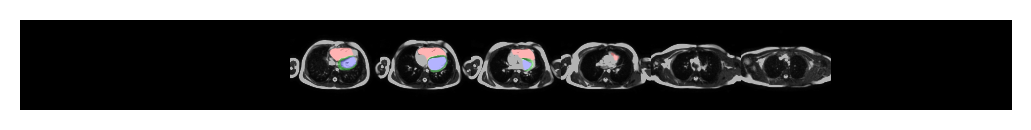

2020-12-17 20:09:40,672 INFO GT on AX


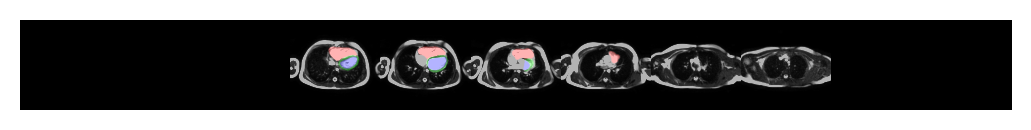

2020-12-17 20:09:41,203 INFO inv mask shape: (24, 256, 256, 4), gt mask shape: (24, 256, 256, 4)
2020-12-17 20:09:41,211 INFO DICE LV: 0.8924574255943298
2020-12-17 20:09:41,218 INFO DICE RV: 0.8528408408164978
2020-12-17 20:09:41,226 INFO DICE MYO: 0.6628504395484924
2020-12-17 20:09:41,295 INFO m: [[ 0.4277 -0.847  -0.3154 -0.996 ]
 [ 0.3354 -0.175   0.926  -0.998 ]
 [-0.8394 -0.5015  0.2091 13.055 ]]
2020-12-17 20:09:41,295 INFO m_mod: [[ 0.4277 -0.847  -0.3154  0.082 ]
 [ 0.3354 -0.175   0.926  -0.3218]
 [-0.8394 -0.5015  0.2091  0.5654]]
2020-12-17 20:09:41,296 INFO m_scaled: [[ 0.4277 -0.847  -0.3154  0.164 ]
 [ 0.3354 -0.175   0.926  -0.6436]
 [-0.8394 -0.5015  0.2091  1.131 ]]
2020-12-17 20:09:41,297 INFO 0000-LV70LENY_2007-03-12_ES_msk.nrrd
2020-12-17 20:09:46,827 INFO DICE LV: 0.8223026394844055
2020-12-17 20:09:46,915 INFO DICE RV: 0.7726788520812988
2020-12-17 20:09:47,004 INFO DICE MYO: 0.7318791747093201
2020-12-17 20:09:47,525 INFO Predicted mask rotated to AX on origina

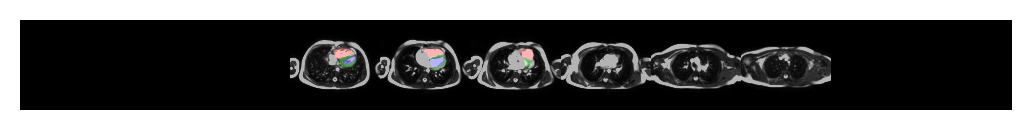

2020-12-17 20:09:47,989 INFO GT on AX


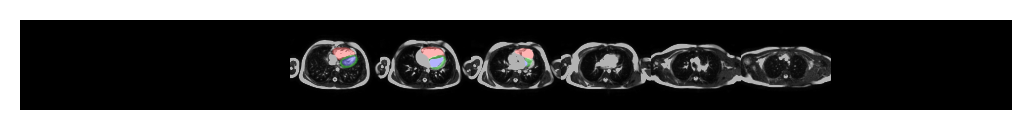

2020-12-17 20:09:48,519 INFO inv mask shape: (24, 256, 256, 4), gt mask shape: (24, 256, 256, 4)
2020-12-17 20:09:48,526 INFO DICE LV: 0.8232453465461731
2020-12-17 20:09:48,532 INFO DICE RV: 0.7881399393081665
2020-12-17 20:09:48,539 INFO DICE MYO: 0.7366237640380859
2020-12-17 20:09:48,623 INFO m: [[ 0.4282 -0.8496 -0.3079 -0.996 ]
 [ 0.3347 -0.1674  0.9277 -0.998 ]
 [-0.8394 -0.5     0.2125 12.984 ]]
2020-12-17 20:09:48,623 INFO m_mod: [[ 0.4282  -0.8496  -0.3079   0.08154]
 [ 0.3347  -0.1674   0.9277  -0.3203 ]
 [-0.8394  -0.5      0.2125   0.563  ]]
2020-12-17 20:09:48,624 INFO m_scaled: [[ 0.4282 -0.8496 -0.3079  0.1631]
 [ 0.3347 -0.1674  0.9277 -0.6406]
 [-0.8394 -0.5     0.2125  1.126 ]]
2020-12-17 20:09:48,625 INFO 0000-MA4HVCMK_2006-06-22_ED_msk.nrrd
2020-12-17 20:09:53,924 INFO DICE LV: 0.9216897487640381
2020-12-17 20:09:54,001 INFO DICE RV: 0.7899386286735535
2020-12-17 20:09:54,079 INFO DICE MYO: 0.6898707747459412
2020-12-17 20:09:54,614 INFO Predicted mask rotated to A

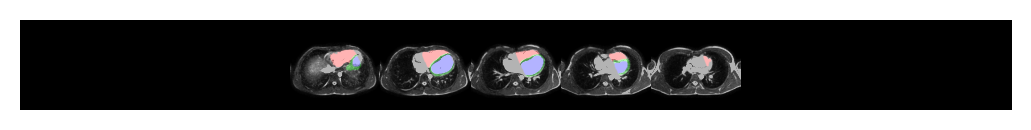

2020-12-17 20:09:55,091 INFO GT on AX


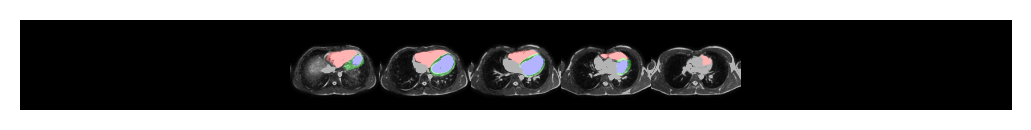

2020-12-17 20:09:55,612 INFO inv mask shape: (20, 256, 256, 4), gt mask shape: (20, 256, 256, 4)
2020-12-17 20:09:55,618 INFO DICE LV: 0.9261602163314819
2020-12-17 20:09:55,623 INFO DICE RV: 0.792401134967804
2020-12-17 20:09:55,629 INFO DICE MYO: 0.7037211060523987
2020-12-17 20:09:55,707 INFO m: [[ 0.428  -0.8486 -0.31   -0.996 ]
 [ 0.335  -0.1696  0.927  -0.998 ]
 [-0.8394 -0.5005  0.2117 13.    ]]
2020-12-17 20:09:55,708 INFO m_mod: [[ 0.428  -0.8486 -0.31    0.0816]
 [ 0.335  -0.1696  0.927  -0.3203]
 [-0.8394 -0.5005  0.2117  0.563 ]]
2020-12-17 20:09:55,708 INFO m_scaled: [[ 0.428  -0.8486 -0.31    0.1632]
 [ 0.335  -0.1696  0.927  -0.6406]
 [-0.8394 -0.5005  0.2117  1.126 ]]
2020-12-17 20:09:55,709 INFO 0000-MA4HVCMK_2006-06-22_ES_msk.nrrd
2020-12-17 20:10:00,989 INFO DICE LV: 0.8833622336387634
2020-12-17 20:10:01,078 INFO DICE RV: 0.7493796348571777
2020-12-17 20:10:01,166 INFO DICE MYO: 0.7282246351242065
2020-12-17 20:10:01,687 INFO Predicted mask rotated to AX on original

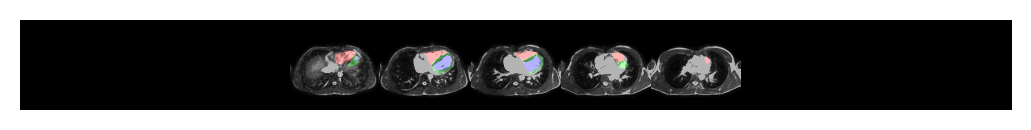

2020-12-17 20:10:02,156 INFO GT on AX


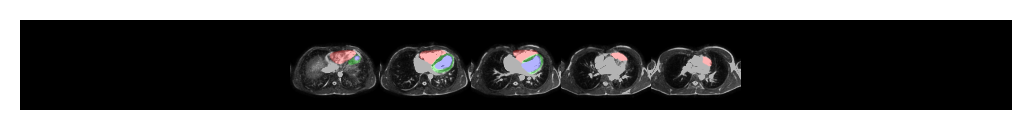

2020-12-17 20:10:02,652 INFO inv mask shape: (20, 256, 256, 4), gt mask shape: (20, 256, 256, 4)
2020-12-17 20:10:02,659 INFO DICE LV: 0.8873517513275146
2020-12-17 20:10:02,664 INFO DICE RV: 0.777951180934906
2020-12-17 20:10:02,670 INFO DICE MYO: 0.7223601937294006
2020-12-17 20:10:02,746 INFO m: [[ 0.4282 -0.849  -0.3093 -0.996 ]
 [ 0.3347 -0.1691  0.9272 -0.998 ]
 [-0.8394 -0.5005  0.2117 12.99  ]]
2020-12-17 20:10:02,747 INFO m_mod: [[ 0.4282 -0.849  -0.3093  0.0816]
 [ 0.3347 -0.1691  0.9272 -0.3203]
 [-0.8394 -0.5005  0.2117  0.563 ]]
2020-12-17 20:10:02,747 INFO m_scaled: [[ 0.4282 -0.849  -0.3093  0.1632]
 [ 0.3347 -0.1691  0.9272 -0.6406]
 [-0.8394 -0.5005  0.2117  1.126 ]]


In [13]:
# predict on all test images, once with postprocessing, and once without
experiment_identifier = config['EXPERIMENT'].replace('/', '_')
export_path = 'data/predicted/{}/3D/'.format(experiment_identifier)
use_modified_translation = FOCUS_LOSS # True, if we use the unet extension to learn a second set of translation parameters
logging.info('Use modified translation to scale: {}'.format(use_modified_translation))

# make predictions with different parameters in the same flow
for i in range(ax_full.shape[0]):
    select_image_in_batch_(im=i,slice_n=5, debug=False,export_path=export_path, save=True, postprocess=True, use_mod_translation=use_modified_translation)

# Further tests, where do our model fail, do we over- or under-segment

In [26]:
print(gt.shape)
print(pred.shape)
print(ax2sax.shape)

(160, 224, 224, 3)
(160, 224, 224, 4)
(1, 160, 224, 224, 1)


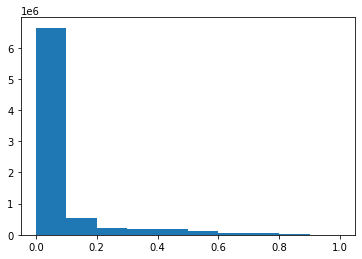

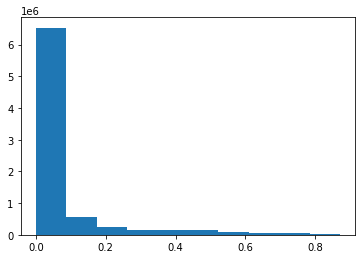

In [32]:
from src.data.Preprocess import clip_quantile
temp = ax2sax[0]
temp_a = clip_quantile(temp, .999)
#show_2D_or_3D(temp)
plt.hist(temp.flatten())
plt.show()
plt.hist(temp_a.flatten())
plt.show()

In [33]:
temp_pred = unet_model.predict(x=[ax2sax])
temp_a_pred = unet_model.predict(x=[temp_a[np.newaxis,...]])

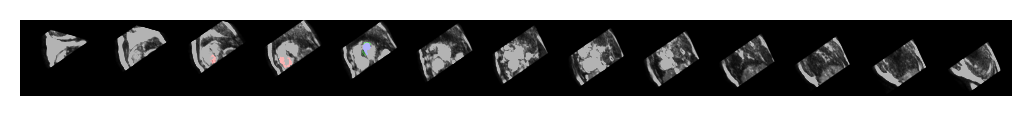

In [39]:
show_2D_or_3D(temp, temp_pred[0])
plt.show()

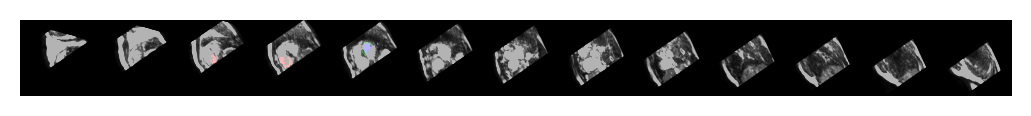

In [40]:
show_2D_or_3D(temp_a, temp_a_pred[0])
plt.show()

In [31]:
temp2.shape

(1, 160, 224, 224, 3)

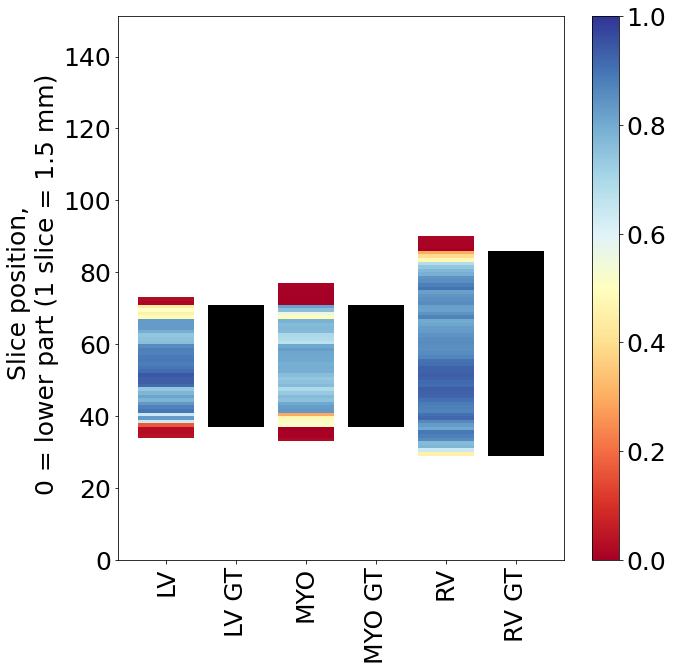

In [22]:
from src.visualization.Visualize import plot_dice_per_slice_bar, plot_dice_per_slice_line
plot_dice_per_slice_bar(gt,pred)